In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **SUL DATASET**

Il dataset è una versione pre-processata del dataset **OASIS Alzheimer's Detection** (un dataset di immagini MRI del cervello di 461 pazienti) utilizzato per rilevare i segni precoci dell’Alzheimer.

Poiché le immagini MRI sono 3D, sono state divise lungo l'asse z (l'asse della profondità del cervello) in 175 fette e sono state selezionate le fette che vanno dalla 65esima alla 110ecima al fine di ridurre il numero di immagini e concentrarsi sulle sezioni cerebrali rilevanti per l'analisi della demenza; Questo approccio ha generato immagini 2D per ogni paziente.

Lo stesso approccio è stato utilizzato per le versioni delle MRI con segmentazione delle aree cerebrali offerte da OASIS effettuate tramite FSL FAST.

****
****

Le immagini sono classificate in **quattro sottoclassi**, in base alla progressione della malattia:

*   Moderate dementia (affetto da demenza)

*   Very mild dementia (affetto da demenza molto lieve)
* Mild dementia (affetto da demenza lieve)
* Non-demented (non affetto da demenza)


*La classificazione dei pazienti è stata effettuata sulla base delle valutazioni CDR (Clinical Dementia Rating), un punteggio che valuta la severità della demenza.*



In [2]:
# Import

import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import zipfile
import os
import matplotlib.patches as mpatches
import numpy as np
from PIL import Image
import math
import shutil
from numpy.lib.stride_tricks import as_strided
import pandas as pd
from numba import njit
from tabulate import tabulate

# **OPERAZIONI SUL DATASET**

### Operazioni preliminari

In [3]:
# Estrazione dataset
ds_path = '/content/drive/MyDrive/Alzheimer-detection-project/train_ds.zip'
if not os.path.exists(ds_path):
  print(f"La cartella {ds_path} non esiste. Procedo con l'estrazione...")

  zip_path = "/content/drive/My Drive/Alzheimer-detection-project/oasis 1.zip"
  extract_folder = "/content/Alzheimer-detection-project"

  os.makedirs(extract_folder, exist_ok=True)

  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)
  print("File estratti:", os.listdir(extract_folder))

else:
  print(f"La cartella {ds_path} esiste. Procedo con la copia...")
  zip_path = "/content/drive/MyDrive/Alzheimer-detection-project/train_ds.zip"
  extract_folder = '/content/Alzheimer-detection-project'
  oasis1_path = os.path.join(extract_folder, "oasis 1")

  os.makedirs(oasis1_path, exist_ok=True)

  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(oasis1_path)

La cartella /content/drive/MyDrive/Alzheimer-detection-project/train_ds.zip esiste. Procedo con la copia...


In [4]:
oasis1_path = os.path.join(extract_folder, "oasis 1")
if not os.path.exists(ds_path):
  categories = ['Moderate Dementia', 'Mild Dementia', 'Very Mild Dementia', 'Non Demented']
else:
  categories = ['Mild to Moderate Dementia', 'Very Mild Dementia', 'Non Demented']
for category in categories:
  category_path = os.path.join(oasis1_path, category)
  mri_segmented_path=os.path.join(category_path, 'mri segmented')
  mri_path= os.path.join(category_path, 'mri scan')

In [5]:
# Rimozione files inutili

for dirpath, dirnames, filenames in os.walk(oasis1_path):
  for filename in filenames:
    if filename == ".DS_Store":
      file_path = os.path.join(dirpath, filename)
      os.remove(file_path)
      print(f"Rimosso: {file_path}")

### **VISUALIZZAZIONE GRAFICI** di distribuzione delle classi

numero foto Moderate Dementia: 92
numero foto Mild Dementia: 1288
numero foto Very Mild Dementia: 3220
numero foto Non Demented: 15456


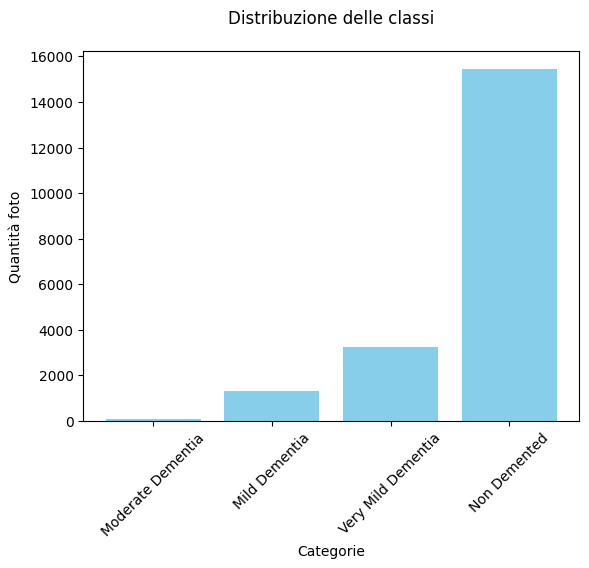

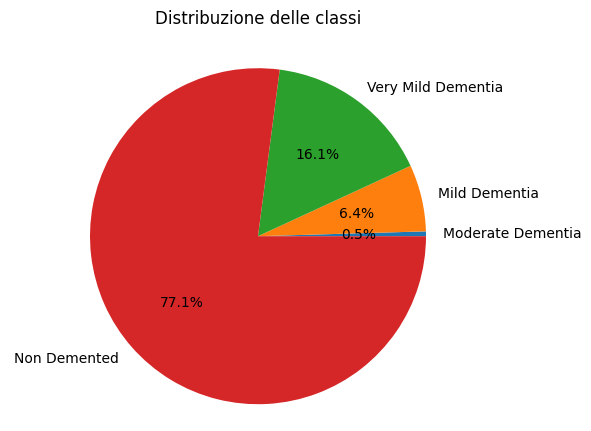

In [ ]:
# Numero di immagini per categoria - grafico di distribuzione delle classi

somma=0
valori=[]

for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_path= os.path.join(category_path, 'mri scan')
    for patient in os.listdir(mri_path):
      images= os.listdir(os.path.join(mri_path, patient))
      somma=somma+len(images)
    print(f'numero foto {category}: {somma}')
    valori.append(somma)
    somma=0

# Visualizzazione tramite istogramma
plt.bar(categories, valori, color='skyblue')
plt.title('Distribuzione delle classi', pad=20)
plt.xlabel('Categorie')
plt.xticks(rotation=45)
plt.ylabel('Quantità foto')
plt.show()
print(f" ")

# Visualizzazione tramite grafico a torta
plt.pie(valori, labels=categories, autopct='%1.1f%%', startangle=0)
plt.title('Distribuzione delle classi',pad=20)
plt.axis('equal')
plt.show()




### **APPROCCI ALLO SBILANCIAMENTO DEL DATASET**

Il dataset è estremamente sbilanciato.

 **APPROCCI ADOTTATI PER AFFRONTARE IL PROBLEMA DELLO SBILANCIAMENTO**:

- **Unione delle due classi minoritarie** (Mild Dementia e Moderate Demenntia) dato che il focus del progetto è una early detection dell'alzheimer.
- **Downsampling parziale della classe maggioritaria** (Non Demented) per limitare il rischio di bias.
- **Bilanciamento delle classi tramiti pesi** (class weights) durante la fase di addestramento per compensare le differenze residue.

In [ ]:
# Sposto i files da Moderate dementia in Mild Dementia

mod_d_path=os.path.join(oasis1_path, "Moderate Dementia")
mild_d_path=os.path.join(oasis1_path, "Mild Dementia")
source_path=os.path.join(mod_d_path, "mri scan")
dest_path=os.path.join(mild_d_path, "mri scan")

for folder in os.listdir(source_path):
  source_file=os.path.join(source_path, folder)
  shutil.move(source_file, dest_path)

source_path=os.path.join(mod_d_path, "mri segmented")
dest_path=os.path.join(mild_d_path, "mri segmented")
for folder in os.listdir(source_path):
  source_file=os.path.join(source_path, folder)
  shutil.move(source_file, dest_path)

In [ ]:
# Rinomino la cartella
mild_to_mod_path= os.path.join(oasis1_path, "Mild to Moderate Dementia")
if os.path.exists(mild_d_path):
    os.rename(mild_d_path, mild_to_mod_path)
    print("Cartella rinominata con successo.")
else:
    print("La cartella di origine non esiste.")

categories = ['Mild to Moderate Dementia', 'Very Mild Dementia', 'Non Demented']

# Elimino la cartella vuota
cartella_da_eliminare = os.path.join(oasis1_path, "Moderate Dementia")
shutil.rmtree(cartella_da_eliminare)

Cartella rinominata con successo.


In [ ]:
# Downsampling della classe maggioritaria
nd_path=os.path.join(oasis1_path, "Non Demented")
mri_path=os.path.join(nd_path, "mri scan")
mri_seg_path=os.path.join(nd_path, "mri segmented")

n=200
folders=os.listdir(mri_path)
to_delete=random.sample(folders, n)

for folder in to_delete:
  folder_seg= f"{folder.strip()} seg"
  path=os.path.join(mri_path, folder)
  path_seg=os.path.join(mri_seg_path, folder_seg)
  shutil.rmtree(path)
  shutil.rmtree(path_seg)

### **VISUALIZZAZIONE GRAFICI** di distribuzione delle classi in seguito a approcci per il bilanciamento

numero foto Mild to Moderate Dementia: 1380
numero foto Very Mild Dementia: 3220
numero foto Non Demented: 6256


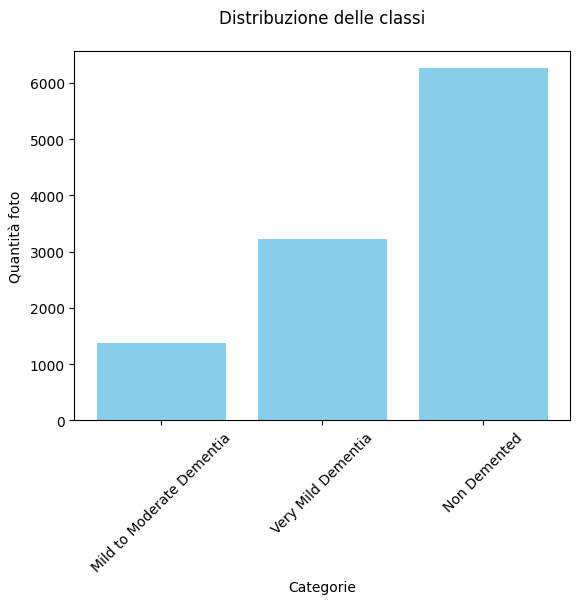

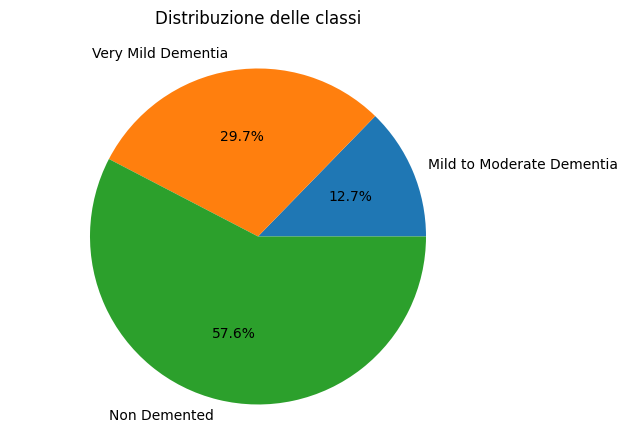

In [ ]:
# Numero di immagini per categoria - grafico di distribuzione delle classi
#dopo unione delle cartelle e downsampling

somma=0
valori=[]

for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_path= os.path.join(category_path, 'mri scan')
    for patient in os.listdir(mri_path):
      images= os.listdir(os.path.join(mri_path, patient))
      somma=somma+len(images)
    print(f'numero foto {category}: {somma}')
    valori.append(somma)
    somma=0

# Visualizzazione tramite istogramma
plt.bar(categories, valori, color='skyblue')
plt.title('Distribuzione delle classi', pad=20)
plt.xlabel('Categorie')
plt.xticks(rotation=45)
plt.ylabel('Quantità foto')
plt.show()
print(f" ")

# Visualizzazione tramite grafico a torta
plt.pie(valori, labels=categories, autopct='%1.1f%%', startangle=0)
plt.title('Distribuzione delle classi',pad=20)
plt.axis('equal')
plt.show()

### **VISUALIZZAZIONE DI IMMAGINI A CAMPIONE** dal dataset

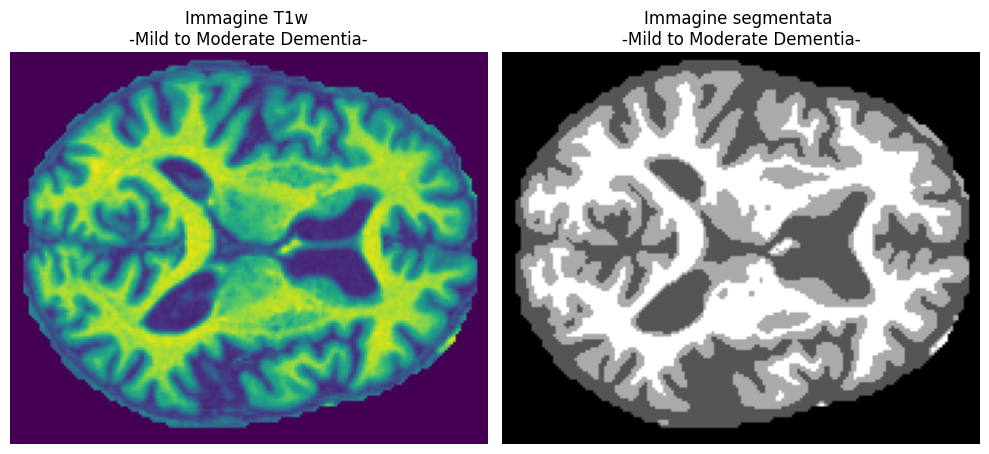

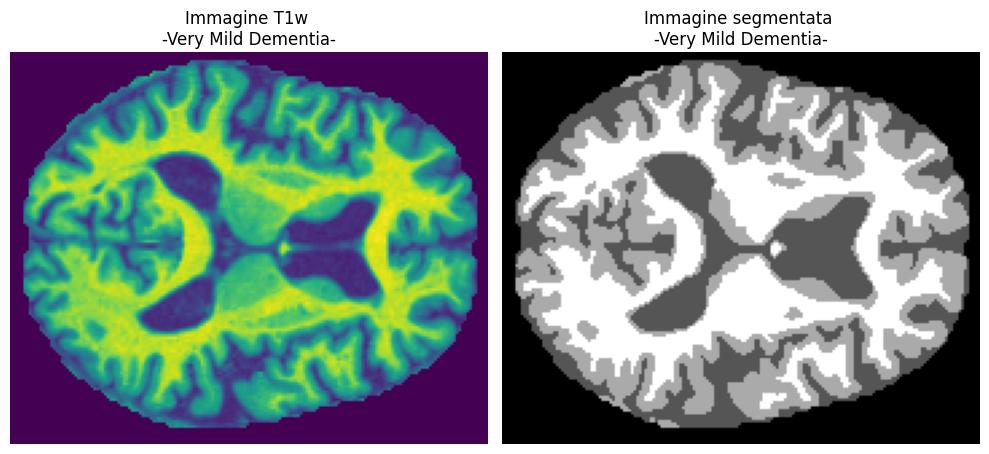

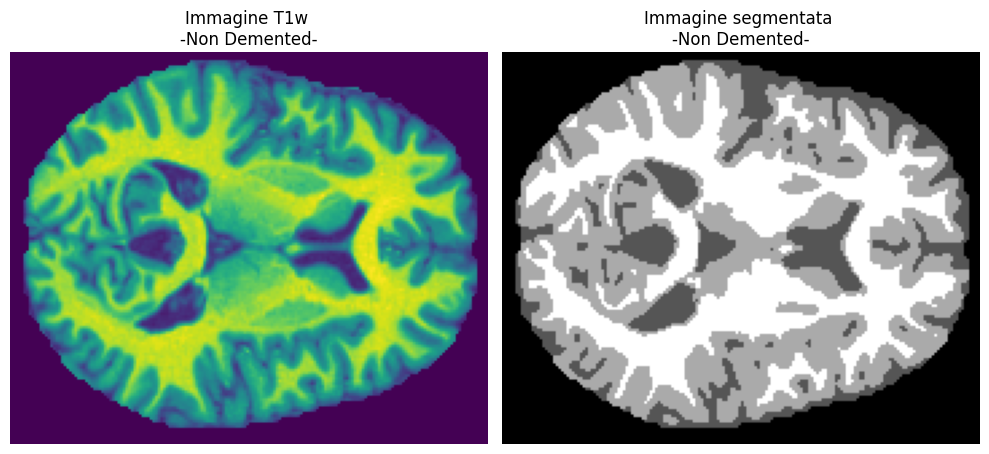

In [ ]:
#VISUALIZZAZIONE DI IMMAGINI A CAMPIONE

# Scelta randomica della slice
#folders=os.listdir(mri_path)
#random_folder = random.choice(folders)
#patient_path= os.path.join(mri_path, random_folder)
#random_slice = random.choice(os.listdir(patient_path))

# Stampa di un immagine segmentata e un immagine T1w per categoria
for category in categories:
  category_path = os.path.join(oasis1_path, category)
  mri_segmented_path=os.path.join(category_path, 'mri segmented')
  mri_path= os.path.join(category_path, 'mri scan')
  folders=os.listdir(mri_path)
  random_folder = random.choice(folders)
  random_folder_seg= f"{random_folder.strip()} seg"

  patient_path= os.path.join(mri_path, random_folder)
  patient_path_seg= os.path.join(mri_segmented_path, random_folder_seg)

  img_path = os.path.join(patient_path, 'slice_85.png')
  img = mpimg.imread(img_path)
  img_seg_path = os.path.join(patient_path_seg, 'slice_85.png')
  img_seg = mpimg.imread(img_seg_path)

  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].imshow(img)
  axes[0].set_title(f"Immagine T1w \n-{category}-")
  axes[0].axis('off')

  axes[1].imshow(img_seg)
  axes[1].set_title(f"Immagine segmentata \n-{category}-")
  axes[1].axis('off')

  plt.tight_layout()
  plt.show()

4 valori differenti: [0.         0.33333334 0.6666667  1.        ]




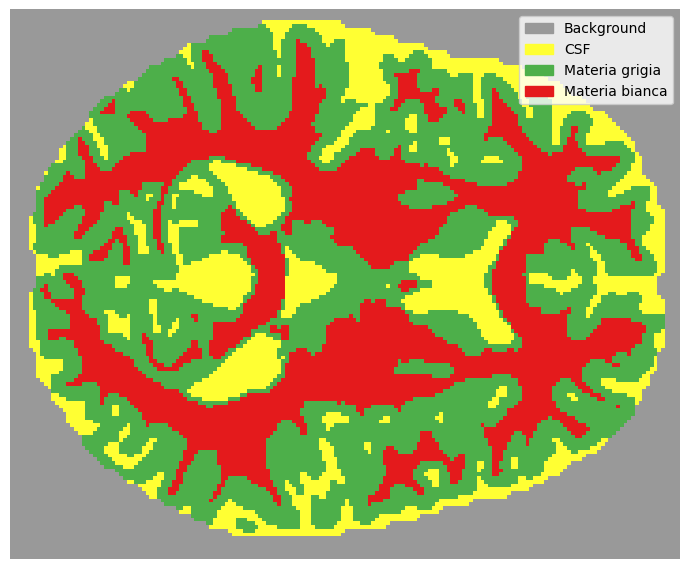

In [ ]:
# Visualizzazione con etichette delle immagini segmentate

# Scelta di un immagine segmentata (parte commentata per randomizzazione)

#category='Very Mild Dementia'
#category_path = os.path.join(oasis1_path, category)
#mri_segmented_path = os.path.join(category_path, 'mri segmented')
#folders = os.listdir(mri_segmented_path)
#random_folder = random.choice(folders)
#patient_path = os.path.join(mri_segmented_path, random_folder)
#random_slice = random.choice(os.listdir(patient_path))
#img_seg_path = os.path.join(patient_path, random_slice)

img_seg = mpimg.imread(img_seg_path)
img_seg = img_seg[:, :, 0]

labels=['Background', 'CSF', 'Materia grigia', 'Materia bianca']
valori_unici = np.unique(img_seg)
print(f"{len(valori_unici)} valori differenti: {valori_unici}\n\n")

# creazione della leggenda e visualizzazione
cmap = plt.cm.Set1_r
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img_seg, cmap=cmap)

patches = []
for i, val in enumerate(valori_unici):
  patch = mpatches.Patch(color=cmap(val), label=labels[i])
  patches.append(patch)
ax.legend(handles=patches, loc='upper right')

ax.axis('off')
plt.tight_layout()
plt.show()

I valori dell'output segmentato sono normalizzati e lo standard è:

| Valore         | Etichetta         |  
|----------------|-------------------|
| `0.0`          | **Background**     |
| `0.33333334`   | **CSF**            |
| `0.6666667`    | **Materia Grigia** |
| `1.0`          | **Materia Bianca** |

### **OPERAZIONI SU DIMENSIONI E CANALI** delle immagini

In [ ]:
# Check dimensioni e canali

images_dimentions=set()
images_channels=set()

# Per ognni immagine in ogni categoria salva dimensioni e numero di canale negli insiemi
for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_path= os.path.join(category_path, 'mri scan')
    for patient in os.listdir(mri_path):
      patient_path=os.path.join(mri_path, patient)
      file_path=os.path.join(patient_path, '.DS_Store')
      if os.path.isfile(file_path):
        os.remove(file_path)
      images= os.listdir(os.path.join(mri_path, patient))

      for image in images:
        image_path=os.path.join(patient_path, image)
        i = mpimg.imread(image_path)
        w, h = i.shape[:2]
        images_dimentions.add((w, h))

        if len(i.shape) == 3:
          channels = i.shape[2]
        else:
          channels = 1
        images_channels.add(channels)

# Controllo del numero di elementi negli insiemi
if len(images_dimentions) == 1:
    print("tutte le immagini hanno le stesse dimensioni", images_dimentions.pop())
else:
    print("NON tutte le immagini hanno le stesse dimensioni:")
    for dim in images_dimentions:
        print(" ", dim)

if len(images_channels) == 1:
    print("tutte le immagini hanno lo stesso numero di canali:", images_channels.pop())
else:
    print("NON tutte le immagini hanno lo stesso numero di canali:")
    for ch in images_channels:
        print(" ", ch)

tutte le immagini hanno le stesse dimensioni (146, 178)
tutte le immagini hanno lo stesso numero di canali: 1


In [ ]:
# Conversione delle immagini MRI in scale di grigi
# Utilizzo Grayscale = 0.299 * R + 0.587 * G + 0.114 * B

for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_path= os.path.join(category_path, 'mri scan')
    for patient in os.listdir(mri_path):
        patient_path = os.path.join(mri_path, patient)
        file_path = os.path.join(patient_path, '.DS_Store')
        if os.path.isfile(file_path):
            os.remove(file_path)
        images = os.listdir(os.path.join(mri_path, patient))

        for image in images:
            image_path = os.path.join(patient_path, image)
            i = mpimg.imread(image_path)

            if len(i.shape) == 3 and i.shape[2] >= 3:
                i_rgb = i[..., :3]

                i_gray = 0.299 * i_rgb[..., 0] + 0.587 * i_rgb[..., 1] + 0.114 * i_rgb[..., 2]
                i_gray = (i_gray * 255).astype(np.uint8)
                gray_img = Image.fromarray(i_gray)
                gray_img.save(image_path)

# Check del nuovo numero di canali
images_channels=set()
for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_path= os.path.join(category_path, 'mri scan')
    for patient in os.listdir(mri_path):
      patient_path=os.path.join(mri_path, patient)
      images= os.listdir(os.path.join(mri_path, patient))

      for image in images:
        image_path=os.path.join(patient_path, image)
        i = mpimg.imread(image_path)

        if len(i.shape) == 3:
          channels = i.shape[2]
        else:
          channels = 1
        images_channels.add(channels)

if len(images_channels) == 1:
    print("tutte le immagini hanno lo stesso numero di canali:", images_channels.pop())
else:
    print("NON tutte le immagini hanno lo stesso numero di canali:")
    for ch in images_channels:
        print(" ", ch)

tutte le immagini hanno lo stesso numero di canali: 1


### **DEVIAZIONE STANDARD E MSE**

 **DEVIAZIONE STANDARD --> misura dove variano di più i pixel**

- STD ALTA: molta variabilità nei valori dei pixel

- STD BASSA: poca variabilità nei valori dei pixel

**MEAN SQUARE ERROR --> misura quanto ogni pixel si allontana dalla media**

- MSE ALTO: alta variabilità intra-classe

- MSE BASSO: bassa variabilità intra-classe

In [ ]:
# Calcolo della deviazione standard e mse

std_interclasse= {}
mse_interclasse={}
std_intraclasse={}
mse_intraclasse={}


selected_slices = ['slice_66.png', 'slice_80.png', 'slice_95.png', 'slice_107.png']  # Esempio: nomi delle slice

for name in selected_slices:  #for name in images per prendere tutte le immagini
  slices_all_categories = []
  for category in categories:
    slices = []
    category_path = os.path.join(oasis1_path, category)
    mri_path= os.path.join(category_path, 'mri scan')
    for patient in os.listdir(mri_path):
      patient_path=os.path.join(mri_path, patient)
      slice_of_interest= os.path.join(patient_path, name)
      i = Image.open(slice_of_interest)
      i_array = np.array(i)
      slices.append(i_array)

    if slices:
        slices_stack_interclasse = np.stack(slices)
        std_map_interclasse = np.std(slices_stack_interclasse, axis=0)
        mean_slice_interclasse = np.mean(slices_stack_interclasse, axis=0)
        mse_map_interclasse = np.mean((slices_stack_interclasse - mean_slice_interclasse) ** 2, axis=0)
        mse_interclasse[(name,category)] = mse_map_interclasse
        std_interclasse[(name, category)] = std_map_interclasse

        slices_all_categories.extend(slices)

  if slices_all_categories:
        slices_stack_intraclasse = np.stack(slices_all_categories)
        std_map_intraclasse = np.std(slices_stack_intraclasse, axis=0)
        mean_slice_intraclasse = np.mean(slices_stack_intraclasse, axis=0)
        mse_map_intraclasse = np.mean((slices_stack_intraclasse - mean_slice_intraclasse) ** 2, axis=0)
        std_intraclasse[name] = std_map_intraclasse
        mse_intraclasse[name] = mse_map_intraclasse

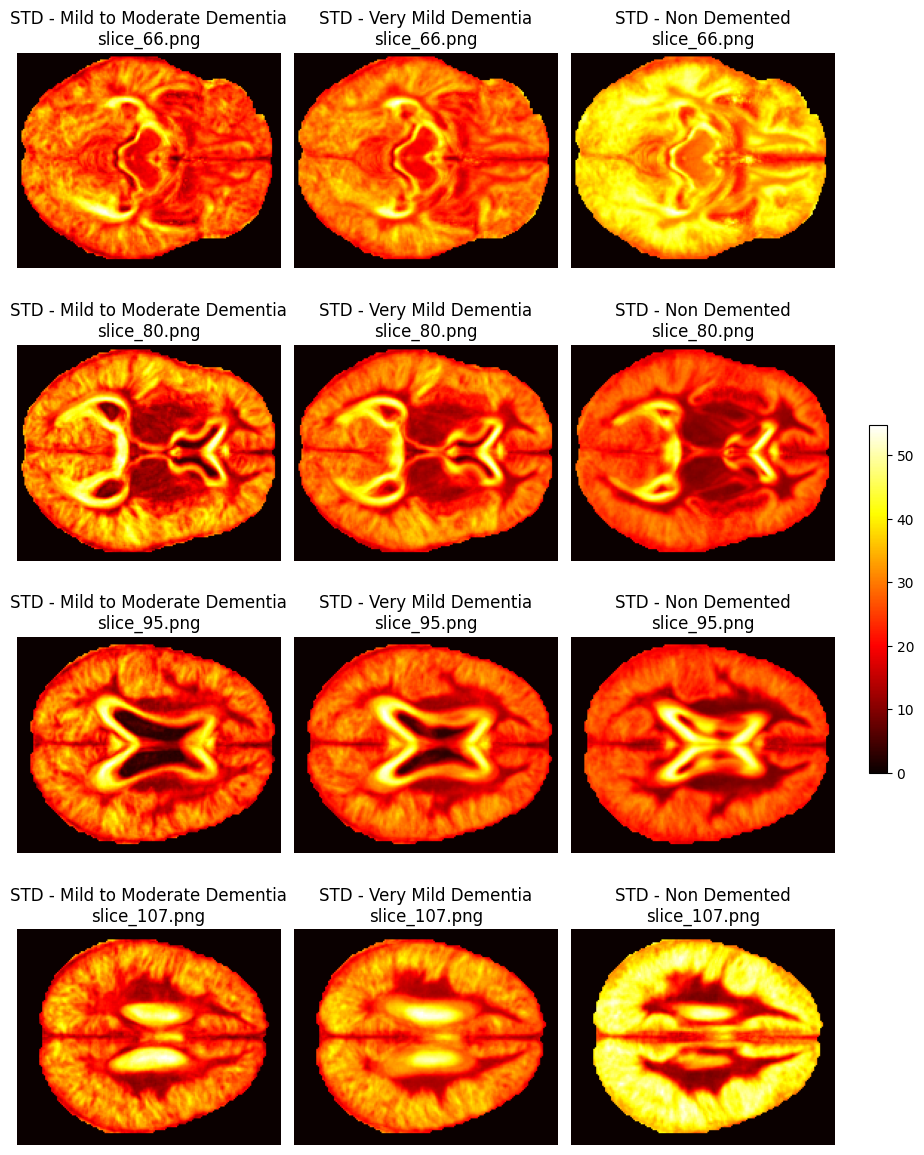

In [ ]:
#  Visualizzazione della deviazione standard (sulla stessa slice) intra classe

columns = 3
imgs = len(std_interclasse)
rows = math.ceil(imgs / columns)
plt.figure(figsize=(columns * 3, rows * 3))

for idx, ((name, category), std_map_interclasse) in enumerate((std_interclasse.items())):
    plt.subplot(rows, columns, idx + 1)
    im = plt.imshow(std_map_interclasse, cmap='hot')
    plt.title(f"STD - {category}\n{name}")
    plt.axis('off')

plt.tight_layout()
plt.colorbar(im, ax=plt.gcf().get_axes(), fraction=0.02, pad=0.04)
plt.show()

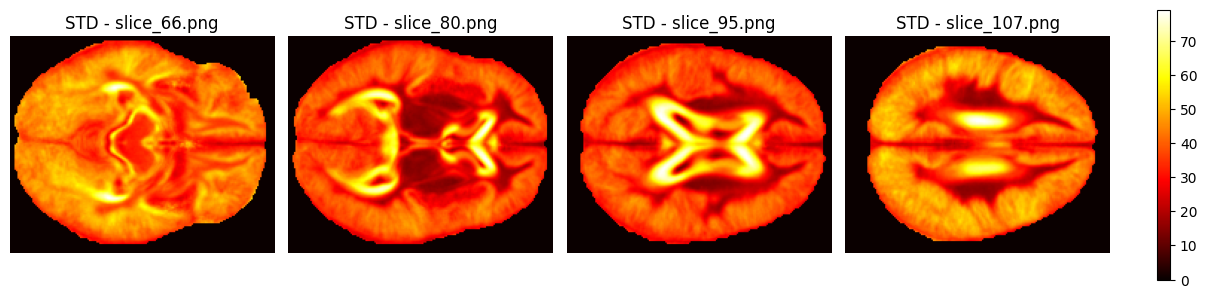

In [ ]:
# Visualizzazione della deviazione standard (sulla stessa slice) inter classe

columns = 4
imgs = len(std_intraclasse)
rows = math.ceil(imgs / columns)
plt.figure(figsize=(columns * 3, rows * 3))

for idx, (name, std_map_intraclasse) in enumerate(std_intraclasse.items()):
    plt.subplot(rows, columns, idx + 1)
    im = plt.imshow(std_map_intraclasse, cmap='hot')
    plt.title(f"STD - {name}")
    plt.axis('off')

plt.tight_layout()
plt.colorbar(im, ax=plt.gcf().get_axes(), fraction=0.02, pad=0.04)
plt.show()

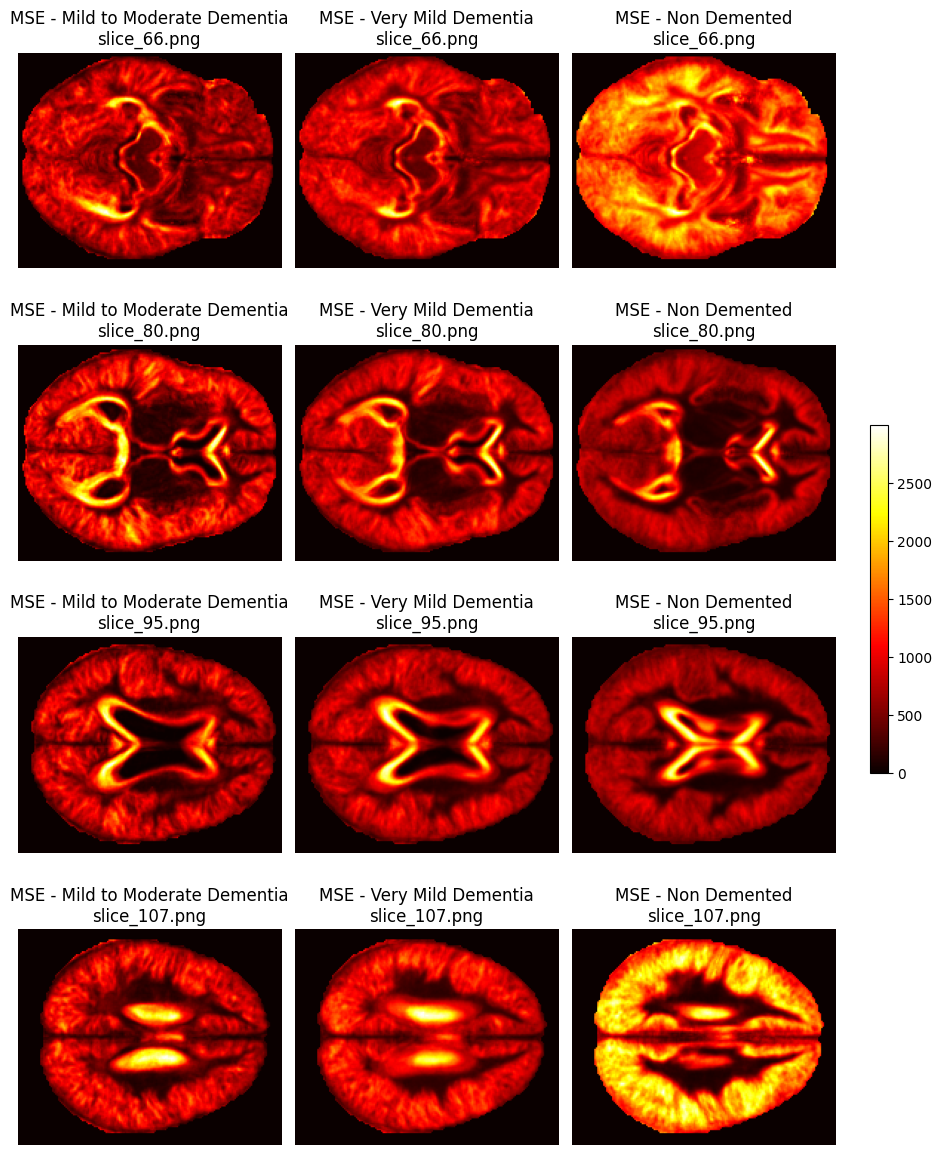

In [ ]:
# Visualizzazione dell'MSE (sulla stessa slice) intra classe

columns = 3
imgs = len(mse_interclasse)
rows = math.ceil(imgs / columns)
plt.figure(figsize=(columns * 3, rows * 3))

for idx, ((name, category), mse_map_interclasse) in enumerate(mse_interclasse.items()):
    plt.subplot(rows, columns, idx + 1)
    im = plt.imshow(mse_map_interclasse, cmap='hot')
    plt.title(f"MSE - {category}\n{name}")
    plt.axis('off')

plt.tight_layout()
plt.colorbar(im, ax=plt.gcf().get_axes(), fraction=0.02, pad=0.04)
plt.show()

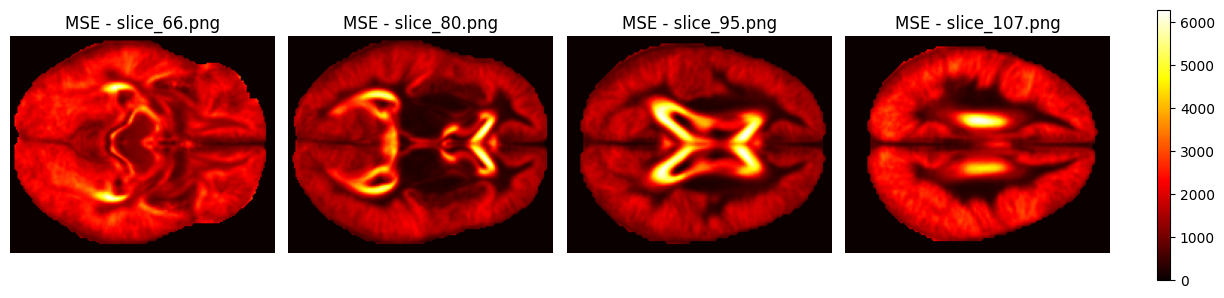

In [ ]:
# Visualizzazione dell'MSE (sulla stessa slice) inter classe

columns = 4
imgs = len(mse_intraclasse)
rows = math.ceil(imgs / columns)
plt.figure(figsize=(columns * 3, rows * 3))

for idx, (name, mse_map_intraclasse) in enumerate(mse_intraclasse.items()):
    plt.subplot(rows, columns, idx + 1)
    im = plt.imshow(mse_map_intraclasse, cmap='hot')
    plt.title(f"MSE - {name}")
    plt.axis('off')

plt.tight_layout()
plt.colorbar(im, ax=plt.gcf().get_axes(), fraction=0.02, pad=0.04)
plt.show()

### **DIVISIONE IN TRAINING SET E TEST SET**

In [6]:
# Divisione in training e test set

labeled_patients=[]
segmented_patients=[]

for cat in categories:
  category_path = os.path.join(oasis1_path, cat)
  mri_path= os.path.join(category_path, 'mri scan')
  mri_segmented_path=os.path.join(category_path, 'mri segmented')
  for patient in os.listdir(mri_path):
    patient_seg= f"{patient.strip()} seg"
    patient_path=os.path.join(mri_path, patient)
    patient_seg_path=os.path.join(mri_segmented_path, patient_seg)
    labeled_patients.append((cat, patient))
    segmented_patients.append((cat, patient_seg))

df=pd.DataFrame(labeled_patients, columns=["label", "patient_id"])
df_seg=pd.DataFrame(segmented_patients, columns=["label", "patient_id"])

In [7]:
from sklearn.model_selection import train_test_split
if not os.path.exists(ds_path):
  train_x, test_x = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label']
  )

  train_x, val_x = train_test_split(
    train_x,
    test_size=0.2,
    random_state=42,
    stratify=train_x['label']
  )

  train_ids = train_x['patient_id'].tolist()
  val_ids = val_x['patient_id'].tolist()
  test_ids = test_x['patient_id'].tolist()

  train_y = df_seg[df_seg['patient_id'].isin([f"{pid} seg" for pid in train_ids])]
  val_y = df_seg[df_seg['patient_id'].isin([f"{pid} seg" for pid in val_ids])]
  test_y = df_seg[df_seg['patient_id'].isin([f"{pid} seg" for pid in test_ids])]

else:

  file_path = '/content/drive/MyDrive/Alzheimer-detection-project/train_ids.pkl'
  #with open(file_path, 'wb') as f:
  #  pickle.dump(train_ids, f)
  with open(file_path, 'rb') as f:
    train_ids= pickle.load(f)

  file_path = '/content/drive/MyDrive/Alzheimer-detection-project/val_ids.pkl'
  #with open(file_path, 'wb') as f:
  #  pickle.dump(val_ids, f)
  with open(file_path, 'rb') as f:
    val_ids = pickle.load(f)

  file_path = '/content/drive/MyDrive/Alzheimer-detection-project/test_ids.pkl'
  #with open(file_path, 'wb') as f:
  #  pickle.dump(test_ids, f)
  with open(file_path, 'rb') as f:
    test_ids = pickle.load(f)

  file_path = '/content/drive/MyDrive/Alzheimer-detection-project/train_y.pkl'
  #with open(file_path, 'wb') as f:
  #  pickle.dump(train_y, f)
  with open(file_path, 'rb') as f:
    train_y = pickle.load(f)

  file_path = '/content/drive/MyDrive/Alzheimer-detection-project/val_y.pkl'
  #with open(file_path, 'wb') as f:
  #  pickle.dump(val_y, f)
  with open(file_path, 'rb') as f:
    val_y = pickle.load(f)

  file_path = '/content/drive/MyDrive/Alzheimer-detection-project/test_y.pkl'
  #with open(file_path, 'wb') as f:
  #  pickle.dump(test_y, f)
  with open(file_path, 'rb') as f:
    test_y = pickle.load(f)
  print("li apro da drive")

print("Numero di pazienti segmentati in train_y:", len(train_y))
print("Numero di pazienti in train_x:", len(train_ids))
print("Numero di pazienti segmentati in val_y:", len(val_y))
print("Numero di pazienti in val_x:", len(val_ids))
print("Numero di pazienti segmentati in test_y:", len(test_y))
print("Numero di pazienti in test_x:", len(test_ids))

li apro da drive
Numero di pazienti segmentati in train_y: 150
Numero di pazienti in train_x: 150
Numero di pazienti segmentati in val_y: 38
Numero di pazienti in val_x: 38
Numero di pazienti segmentati in test_y: 48
Numero di pazienti in test_x: 48


### **CONVERSIONE IMMAGINI SEGMENTATE IN MAPPE DI CLASSI**

In [ ]:
# Funzione per la conversione di immagine segmentata in una mappa di classi intere
value_to_class = {
    0.0: 0,
    1/3: 1,
    2/3: 2,
    1.0: 3
}

def class_map(img, d):
  class_map = np.zeros_like(img, dtype=np.uint8)
  for val, class_id in d.items():
    mask = np.isclose(img, val)
    class_map[mask] = class_id
  return class_map

In [ ]:
# Conversione delle immagini segmentate in mappe
if not os.path.exists(ds_path):
  for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_segmented_path=os.path.join(category_path, 'mri segmented')
    for patient in os.listdir(mri_segmented_path):
      patient_path= os.path.join(mri_segmented_path, patient)
      for filename in os.listdir(patient_path):
        img_path = os.path.join(patient_path, filename)
        img_seg = mpimg.imread(img_path)
        img_seg = img_seg[:, :, 0]
        classmap = class_map(img_seg, value_to_class)
        save_path = os.path.join(patient_path, filename.replace(".png", ".npy"))
        np.save(save_path, classmap)

### **SBILANCIAMENTO TRA CLASSI DELLA SEGMENTAZIONE**

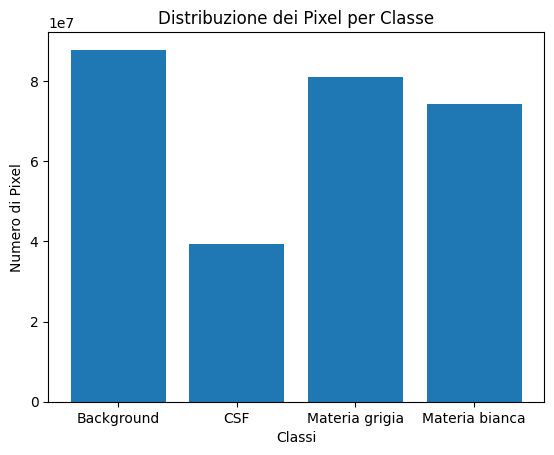

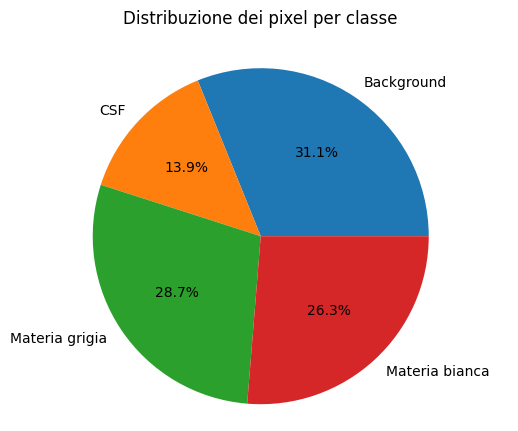

In [8]:
# Calcolo del numero di pixel per ogni classe per vedere se sono presenti sbilanciamenti

labels = ['Background', 'CSF', 'Materia grigia', 'Materia bianca']
total_counts = np.zeros(4, dtype=np.int64)
image_count = 0

for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_segmented_path=os.path.join(category_path, 'mri segmented')
    for patient in os.listdir(mri_segmented_path):
      patient_path= os.path.join(mri_segmented_path, patient)
      for filename in os.listdir(patient_path):
        if not filename.endswith('.npy'):
          continue
        file_path = os.path.join(patient_path, filename)
        class_map = np.load(file_path)
        pixel_counts = np.bincount(class_map.flatten(), minlength=4)
        total_counts += pixel_counts
        image_count += 1
avg_counts = total_counts / image_count


# Visualizzazione tramite istogramma
plt.bar(labels, total_counts)
plt.xlabel('Classi')
plt.ylabel('Numero di Pixel')
plt.title('Distribuzione dei Pixel per Classe')
plt.show()

# Visualizzazione tramite grafico a torta
plt.pie(total_counts, labels=labels, autopct='%1.1f%%', startangle=0)
plt.title('Distribuzione dei pixel per classe',pad=20)
plt.axis('equal')
plt.show()

In [9]:
# Calcolo dei pesi per la loss function

pixels = avg_counts.sum()
class_weights = pixels /(4*avg_counts )



for class_id, weight in enumerate(class_weights):
  print(f"Classe {labels[class_id]}: Peso = {weight:.4f}")
class_weights = np.array(class_weights, dtype=np.float32)



Classe Background: Peso = 0.8034
Classe CSF: Peso = 1.7942
Classe Materia grigia: Peso = 0.8722
Classe Materia bianca: Peso = 0.9511


In [ ]:
# salvo il dataset su cui farò il training su drive

#drive_path = '/content/drive/MyDrive/Alzheimer-detection-project/train_ds'
#shutil.copytree(oasis1_path, drive_path)

'/content/drive/MyDrive/Alzheimer-detection-project/train_ds'

# **DEFINIZIONE DELLA U NET** per la segmentazione

## *Funzioni ausiliarie al forward pass*

### **Funzioni di pooling e upsampling**

In [10]:
# Max pooling

def max_pooling(img, pool_size=2, stride=2):
  if img.ndim == 3:
    img = img[:, :, :, np.newaxis]
  batch_size, img_height, img_width, img_channels = img.shape
  pool_height, pool_width = (pool_size, pool_size)
  output_height = (img_height - pool_height) // stride + 1
  output_width = (img_width - pool_width) // stride + 1
  output = np.zeros((batch_size, output_height, output_width, img_channels))
  for b in range(batch_size):
    for i in range(output_height):
      for j in range(output_width):
        row=i*stride
        column=j*stride
        for c in range(img_channels):
          window = img[b, row:row + pool_height, column:column + pool_width, c]
          output[b,i, j, c] = np.max(window)
  return output

In [11]:
# Upsampling

def upsample(img, scale=2):
  if img.ndim == 3:
    img = img[:, :, :, np.newaxis]

  upsampled = np.repeat(img, scale, axis=1)
  upsampled = np.repeat(upsampled, scale, axis=2)

  return upsampled

### **Funzione di perdita** (loss function)

In [12]:
# Loss function e funzioni ausiliarie

def onehot_encoding(targets, n_classes):
  one_hot = np.eye(n_classes, dtype=np.uint8)[targets]
  return one_hot

def weighted_cross_entropy_loss(targets, predictions, class_weights):
  epsilon = 1e-7
  log_predictions = np.log(predictions + epsilon)
  cross_entropy = -np.sum(targets * log_predictions, axis=-1)
  weights = np.sum(targets * class_weights, axis=-1)
  weighted_cross_entropy = cross_entropy * weights
  loss = np.mean(weighted_cross_entropy)

  return loss

### **Funzioni di attivazione**

In [13]:
# ReLU

def ReLU(img):
  return np.where(img > 0, img, 0.01 * img)

In [14]:
# Softmax - per rendere l'output in probabilità per classe

def softmax(predictions, temperature=0.5):
  if predictions.ndim != 4:
    raise ValueError(f"Expected predictions of shape (B, H, W, C), got {predictions.shape}")
  scaled_preds = predictions / temperature
  exp_preds = np.exp(scaled_preds - np.max(scaled_preds, axis=-1, keepdims=True))
  sum_exp_preds = np.sum(exp_preds, axis=-1, keepdims=True)
  softmax_output = exp_preds / sum_exp_preds

  return softmax_output

### **Funzioni di ottimizzazione**

In [15]:
# Inizializzazione parametri adam

def adam_init(filters):
  m = {k: np.zeros_like(v) for k, v in filters.items()}
  v = {k: np.zeros_like(v) for k, v in filters.items()}
  t = 0
  return m, v, t

In [16]:
def adam_step(filters, grads, m, v, t, lr, beta1=0.9, beta2=0.999, eps=1e-8):
  t += 1
  updated_filters = {}
  grads_map = {
        "encoder1": grads["encoder"][0],
        "encoder2": grads["encoder"][1],
        "decoder1": grads["decoder"][0],
        "decoder2": grads["decoder"][1],
        "bottleneck1": grads["bottleneck"][0],
        "bottleneck2": grads["bottleneck"][1],
        "final": grads["final"]
  }

  for k in filters:
    g = grads_map[k]
    m[k] = beta1 * m[k] + (1 - beta1) * g
    v[k] = beta2 * v[k] + (1 - beta2) * (g ** 2)
    m_hat = m[k] / (1 - beta1 ** t)
    v_hat = v[k] / (1 - beta2 ** t)

    updated_filters[k] = filters[k] - lr * m_hat / (np.sqrt(v_hat) + eps)
  return updated_filters, m, v, t

## *Funzioni per il forward pass*

In [17]:
# Funzione di convoluzione con più filtri

def convolve(imgs, kernels):
  if imgs.ndim == 3:
    imgs = imgs[:, :, :, np.newaxis]

  batch_size, img_height, img_width, in_channels = imgs.shape
  n_kernels, ker_height, ker_width, _ = kernels.shape
  pad_h = ker_height // 2
  pad_w = ker_width // 2
  padded = np.pad(imgs, ((0, 0), (pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='constant')
  output = np.zeros((batch_size, img_height, img_width, n_kernels))

  for i in range(img_height):
    for j in range(img_width):
      patch = padded[:, i:i+ker_height, j:j+ker_width, :]
      output[:, i, j, :] = np.tensordot(patch, kernels, axes=([1,2,3], [1,2,3]))

  return output

In [18]:
# Convoluzione finale

def final_convolve_1x1(imgs, filters):
  filters = filters.reshape(filters.shape[-2], filters.shape[-1])
  return np.einsum('bhwc,co->bhwo', imgs, filters)

In [19]:
# Funzione per la concatenazione

def concatenate(img_contr, img_exp):
  if img_contr.ndim == 3:
    img_contr = img_contr[:, :, :, np.newaxis]
  if img_exp.ndim == 3:
    img_exp = img_exp[:, :, :, np.newaxis]
  batch_size, contr_height, contr_width , _= img_contr.shape
  _, exp_height, exp_width, _ = img_exp.shape
  concatenated = np.concatenate((img_contr, img_exp), axis=3)
  return concatenated

In [20]:
# Encoder

def encoder(imgs, filters):
  blocks=[]
  saved_enc = {}
  saved_enc["input_convolve1"] = imgs

  c=convolve(imgs, filters["encoder1"])
  saved_enc["input_relu1"] = c
  c=ReLU(c)

  blocks.append(c)
  saved_enc["input_convolve2"] = c
  c=convolve(c, filters["encoder2"])
  saved_enc["input_relu2"] = c
  c=ReLU(c)
  blocks.append(c)
  saved_enc["input_maxp"] = c

  c=max_pooling(c)

  return c, blocks, saved_enc

In [21]:
# Decoder

def decoder(imgs, blocks, filters):
  saved = {}

  saved["input_upsample"] = imgs
  c = upsample(imgs)
  saved["upsampled"] = c
  skip = blocks[1]
  saved["skip"] = skip

  c = concatenate(c, skip)
  saved["input_conv1"] = c
  c = convolve(c, filters["decoder1"])
  saved["input_relu1"] = c
  c = ReLU(c)

  saved["input_conv2"] = c
  c = convolve(c, filters["decoder2"])
  saved["input_relu2"] = c
  c = ReLU(c)

  return c, saved

In [22]:
# Bottleneck

def bottleneck(imgs, filters):
  saved_b = {}

  saved_b["input_convolve0"] = imgs
  c=convolve(imgs, filters["bottleneck1"])
  saved_b["convolved0"] = c
  c=ReLU(c)

  saved_b["input_convolve1"] = c
  c=convolve(c, filters["bottleneck2"])
  saved_b["convolved1"] = c
  c=ReLU(c)

  return c , saved_b

## *Funzioni ausiliarie al backward pass*

### **Funzioni di pooling e upsampling**

In [23]:
# Derivata del max pooling

def max_pooling_backward(dout, input, pool_size, stride):

  batch_size, height, width, channels = input.shape
  out_height, out_width = dout.shape[1], dout.shape[2]
  output = np.zeros_like(input)

  for i in range(batch_size):
    for h in range(out_height):
      for w in range(out_width):
        for c in range(channels):
          h_start = h * stride
          h_end = h_start + pool_size
          w_start = w * stride
          w_end = w_start + pool_size

          window = input[i, h_start:h_end, w_start:w_end, c]
          max_pos = np.unravel_index(np.argmax(window), window.shape)
          output[i, h_start + max_pos[0], w_start + max_pos[1], c] += dout[i, h, w, c]

  return output

In [24]:
# Derivata dell'upsampling

def upsample_backward(dout, img, scale=2):
  if img.ndim == 3:
    img = img[:, :, :, np.newaxis]

  batch_size, output_height, output_width, channels = dout.shape
  img_height = output_height // scale
  img_width = output_width // scale

  dinput = dout.reshape(
        batch_size,
        img_height, scale,
        img_width, scale,
        channels
    ).sum(axis=(2, 4))

  return dinput

### **Funzioni di attivazione**

In [25]:
# Derivata della ReLU

def ReLU_backward(grad, input):
  dx = np.ones_like(input)
  dx[input < 0] = 0.01
  return grad * dx

### **Funzioni di perdita** (loss function)

In [26]:
# Gradiente della funzione di loss

def grad(targets, predictions, class_weights):
  epsilon = 1e-7
  predictions = np.clip(predictions, epsilon, 1 - epsilon)
  weights = np.sum(targets * class_weights, axis=-1)
  weights = weights[..., np.newaxis]
  grad = (predictions - targets) * weights
  batch_size = targets.shape[0]
  height = targets.shape[1]
  width = targets.shape[2]
  grad /= (batch_size * height * width)

  return grad

## *Funzioni per il backward pass*

In [27]:
# Derivata della convoluzione con più filtri

def convolve_backward(dout, input, kernels):
  if input.ndim == 3:
    input = input[:, :, :, np.newaxis]
  if dout.ndim == 3:
    dout = dout[:, :, :, np.newaxis]

  batch_size, H, W, in_channels = input.shape
  n_kernels, kH, kW, _ = kernels.shape
  pad_h, pad_w = kH // 2, kW // 2
  padded_input = np.pad(input, ((0,0), (pad_h,pad_h), (pad_w,pad_w), (0,0)), mode='constant')
  dinput_padded = np.zeros_like(padded_input)
  dkernel = np.zeros_like(kernels)

  for i in range(H):
    for j in range(W):
      input_patch = padded_input[:, i:i+kH, j:j+kW, :]
      dout_patch = dout[:, i, j, :]
      dkernel += np.tensordot(dout_patch, input_patch, axes=([0], [0]))
      dinput_padded[:, i:i+kH, j:j+kW, :] += np.tensordot(dout_patch, kernels, axes=([1], [0]))

  dinput = dinput_padded[:, pad_h:pad_h+H, pad_w:pad_w+W, :]
  return dinput, dkernel

In [28]:
# Derivata della convoluzione finale

def final_convolve_1x1_backward(dout, imgs, filters):
  filters = filters[0, 0]
  dimgs = np.einsum('bhwo,co->bhwc', dout, filters)
  dfilters = np.einsum('bhwc,bhwo->co', imgs, dout).reshape(1, 1, *filters.shape)

  return dimgs, dfilters

In [29]:
# Derivata della concatenazione

def concatenate_backward(dout, img_contr, img_exp):
  c1 = img_contr.shape[-1]
  c2 = img_exp.shape[-1]
  dimg_contr = dout[..., :c1]
  dimg_exp = dout[..., c1:c1 + c2]

  return dimg_contr, dimg_exp

In [30]:
# Encoder backward

def encoder_backward(dout, blocks, filters, saved_enc):
  grads = [None, None]
  dmaxpool = max_pooling_backward(dout, saved_enc["input_maxp"], pool_size=2, stride=2)
  dout = ReLU_backward(dmaxpool, saved_enc["input_relu2"])
  dconv1, grads[1] = convolve_backward(dout, saved_enc["input_convolve2"], filters["encoder2"])
  dout = ReLU_backward(dconv1, saved_enc["input_relu1"])
  dconv2, grads[0] = convolve_backward(dout, saved_enc["input_convolve1"], filters["encoder1"])

  return dconv2, grads

In [31]:
# Decoder backwards

def decoder_backward(dout, saved, filters):
  grads = [None, None]
  drelu2 = ReLU_backward(dout, saved["input_relu2"])
  dconv2, grads[1] = convolve_backward(drelu2, saved["input_conv2"], filters["decoder2"])
  drelu1 = ReLU_backward(dconv2, saved["input_relu1"])
  dconv1, grads[0] = convolve_backward(drelu1, saved["input_conv1"], filters["decoder1"])
  dupsampled, dskip = concatenate_backward(dconv1, saved["upsampled"], saved["skip"])
  dinput = upsample_backward(dupsampled, saved["input_upsample"])

  return dinput, dskip, grads

In [32]:
# Bottleneck backwards

def bottleneck_backward(dout, saved, filters):
  grads = [None, None]
  drelu2 = ReLU_backward(dout, saved["convolved1"])
  dconv2, grads[1] = convolve_backward(drelu2, saved["input_convolve1"], filters["bottleneck2"])
  drelu1 = ReLU_backward(dout, saved["convolved0"])
  dconv1, grads[0] = convolve_backward(drelu1, saved["input_convolve0"], filters["bottleneck1"])

  return dconv1, grads

## FUNZIONI DI TRAINING

In [33]:
# FORWARD
def forward_pass(input_img, target_img, filters, class_weights, n_classes):
  saved_fwd = {}
  encoded_img, skip_connections, saved_encoder = encoder(input_img, filters)
  saved_fwd["saved_encoder"] = saved_encoder
  bottleneck_img, saved_bot= bottleneck(encoded_img, filters)
  saved_fwd["saved_bot"] = saved_bot
  decoded_img, saved_decoder = decoder(bottleneck_img, skip_connections, filters)
  saved_fwd["saved_decoder"] = saved_decoder
  saved_fwd["input_fc"] = decoded_img
  final_output = final_convolve_1x1(decoded_img, filters["final"])
  final_output=softmax(final_output)
  saved_fwd["input_loss"] = final_output
  loss =weighted_cross_entropy_loss(target_img, final_output, class_weights)

  return final_output, loss, saved_fwd, skip_connections

In [34]:
# BACKWARD
def backward_pass( target_img, saved_fwd , filters, class_weights, skip_connections):

  grad_loss = grad(target_img, saved_fwd["input_loss"], class_weights)
  d_convolve, final_filters_grads= final_convolve_1x1_backward(grad_loss, saved_fwd["input_fc"], filters["final"])
  d_decoder, d_skip, decoder_grads = decoder_backward(d_convolve, saved_fwd["saved_decoder"], filters)
  d_bot, bot_grads = bottleneck_backward(d_decoder, saved_fwd["saved_bot"], filters)
  d_encoder, encoder_grads = encoder_backward(d_bot, d_skip, filters, saved_fwd["saved_encoder"])
  grads = {
        "encoder": encoder_grads,
        "bottleneck": bot_grads,
        "decoder": decoder_grads,
        "final": final_filters_grads
    }

  return d_encoder, grads

In [35]:
# Train step

def train_step(imgs, targets, filters, class_weights, learning_rate, n_classes):

  output, loss, saved_fwd, skip_connections = forward_pass(imgs, targets, filters,
                                                             class_weights, n_classes)
  final_loss, grads = backward_pass (targets, saved_fwd, filters,
                                    class_weights, skip_connections)
  return loss, filters, output, grads

In [36]:
# Test step

def predict(imgs,targets, filters,class_weights, n_classes):
    output, _, _, _ = forward_pass(imgs, targets, filters, class_weights, n_classes)
    return output

In [37]:
# Validation step

def validation_step(X_batch, y_batch, filters, class_weights, num_classes):
  predictions, loss, _, _ = forward_pass(X_batch, y_batch, filters, class_weights, num_classes)
  return loss

#**PREPARAZIONE DATI DA PASSARE ALLA RETE**

In [38]:
image_paths_train = []
mask_paths_train = []
val_image_paths=[]
val_mask_paths=[]
test_image_paths=[]
test_mask_paths=[]

for cat in categories:
  category_path = os.path.join(oasis1_path, cat)
  mri_path= os.path.join(category_path, 'mri scan')
  mri_segmented_path=os.path.join(category_path, 'mri segmented')
  for patient in train_ids:
    patient_img_dir = os.path.join(mri_path, patient)
    patient_mask_dir = os.path.join(mri_segmented_path, f"{patient} seg")
    if not os.path.exists(patient_img_dir) or not os.path.exists(patient_mask_dir):
      continue
    for image in os.listdir(patient_img_dir):
      img_path = os.path.join(patient_img_dir, image)
      mask_name = image.replace(".png", ".npy")
      mask_path = os.path.join(patient_mask_dir, mask_name)
      image_paths_train.append(img_path)
      mask_paths_train.append(mask_path)

combined = list(zip(image_paths_train, mask_paths_train))
random.shuffle(combined)
image_paths_train, mask_paths_train = zip(*combined)
image_paths_train, mask_paths_train = list(image_paths_train), list(mask_paths_train)

for cat in categories:
  category_path = os.path.join(oasis1_path, cat)
  mri_path= os.path.join(category_path, 'mri scan')
  mri_segmented_path=os.path.join(category_path, 'mri segmented')
  for patient in val_ids:
    patient_img_dir = os.path.join(mri_path, patient)
    patient_mask_dir = os.path.join(mri_segmented_path, f"{patient} seg")
    if not os.path.exists(patient_img_dir) or not os.path.exists(patient_mask_dir):
      continue
    for image in os.listdir(patient_img_dir):
      img_path = os.path.join(patient_img_dir, image)
      mask_name = image.replace(".png", ".npy")
      mask_path = os.path.join(patient_mask_dir, mask_name)
      val_image_paths.append(img_path)
      val_mask_paths.append(mask_path)

for cat in categories:
  category_path = os.path.join(oasis1_path, cat)
  mri_path= os.path.join(category_path, 'mri scan')
  mri_segmented_path=os.path.join(category_path, 'mri segmented')
  for patient in test_ids:
    patient_img_dir = os.path.join(mri_path, patient)
    patient_mask_dir = os.path.join(mri_segmented_path, f"{patient} seg")
    if not os.path.exists(patient_img_dir) or not os.path.exists(patient_mask_dir):
      continue
    for image in os.listdir(patient_img_dir):
      img_path = os.path.join(patient_img_dir, image)
      mask_name = image.replace(".png", ".npy")
      mask_path = os.path.join(patient_mask_dir, mask_name)
      test_image_paths.append(img_path)
      test_mask_paths.append(mask_path)

In [39]:
# Funzione per creare i batch

def batch_generator(image_paths, mask_paths, batch_size, num_classes=4):
  num_samples = len(image_paths)
  indices = np.arange(num_samples)
  np.random.shuffle(indices)

  for start in range(0, num_samples, batch_size):
    end = min(start + batch_size, num_samples)
    batch_idx = indices[start:end]

    X = []
    y = []
    batch_mask_paths = []
    for i in batch_idx:
      img = Image.open(image_paths[i])
      img = np.array(img, dtype=np.float32) / 255.0
      mask = np.load(mask_paths[i])
      X.append(img[..., np.newaxis])

      one_hot = onehot_encoding(mask, num_classes)
      y.append(one_hot)
      batch_mask_paths.append(mask_paths[i])

    X = np.stack(X)
    y = np.stack(y)
    yield X, y,batch_mask_paths

In [40]:
# funzione per inizializzazione dei filtri

def he_init(shape):

  fan_in = np.prod(shape[1:])
  std = np.sqrt(2. / fan_in)
  return np.random.randn(*shape) * std

In [41]:
# Parametri e filtri

num_epochs = 4
n_classes = 4
batch_size = 10
learning_rate = 1e-3
n_filtri_enc = 16
n_filtri_bottleneck = 32
n_filtri_dec = 32

filters = {
    "encoder1": he_init((n_filtri_enc, 3, 3, 1)),
    "encoder2": he_init((n_filtri_enc, 3, 3, n_filtri_enc)),
    "bottleneck1": he_init((n_filtri_bottleneck, 3, 3, n_filtri_enc)),
    "bottleneck2": he_init((n_filtri_bottleneck, 3, 3, n_filtri_bottleneck)),
    "decoder1": he_init((n_filtri_dec, 3, 3, n_filtri_bottleneck+ n_filtri_enc)),
    "decoder2": he_init((n_filtri_dec, 3, 3, n_filtri_dec)),
    "final": np.random.randn(1, 1, n_filtri_dec, n_classes) * np.sqrt(2. / n_filtri_dec)
}

In [42]:
def colorize_prediction(pred_label):
  color_map = {
        0: (0, 0, 0),       # Background - Nero
        1: (0, 0, 255),     # CSF - Blu
        2: (0, 255, 0),     # Materia grigia - Verde
        3: (255, 0, 0)      # Materia bianca - Rosso
    }

  h, w = pred_label.shape
  color_img = np.zeros((h, w, 3), dtype=np.uint8)
  for class_id, color in color_map.items():
    color_img[pred_label == class_id] = color

  return color_img

### divisione in fold

In [ ]:
# Divisione in fold

image_paths_folds = list(image_paths_train[:100])
mask_paths_folds = list(mask_paths_train[:100])
k = 3
total = len(image_paths_folds)
fold_size = total // k

folds = []
for i in range(k):
  start = i * fold_size
  end = (i + 1) * fold_size if i < k - 1 else total
  folds.append((image_paths_folds[start:end], mask_paths_folds[start:end]))


# **METRICHE DI VALUTAZIONE DEL MODELLO DI SEGMENTAZIONE**

In [43]:
# Dice Coefficient

def dice_coefficient_from_softmax(targets, predictions, epsilon=1e-7):
  pred_labels = np.argmax(predictions, axis=-1)
  pred_one_hot=onehot_encoding(pred_labels, 4)
  intersection = np.sum(targets * pred_one_hot, axis=(1, 2))
  sum_true = np.sum(targets, axis=(1, 2))
  sum_pred = np.sum(pred_one_hot, axis=(1, 2))
  dice_per_class_per_sample = (2. * intersection + epsilon) / (sum_true + sum_pred + epsilon)

  dice_mean_per_sample = np.mean(dice_per_class_per_sample, axis=1)
  dice_mean = np.mean(dice_mean_per_sample)
  dice_per_class = np.mean(dice_per_class_per_sample, axis=0)

  return dice_mean, dice_per_class

In [44]:
# Pixel accuracy

def pixel_accuracy(targets, pred):
  y_true_labels = np.argmax(targets, axis=-1)
  y_pred_labels = np.argmax(pred, axis=-1)

  correct = np.sum(y_true_labels == y_pred_labels)
  total = y_true_labels.size

  return correct / total

In [45]:
# Accuracy per classe

def class_accuracy(targets, pred):
  true_labels = np.argmax(targets, axis=-1)
  pred_labels = np.argmax(pred, axis=-1)
  n_classes = targets.shape[-1]

  accuracies = []
  for c in range(n_classes):
    mask = (true_labels == c)
    correct = (pred_labels == c) & mask
    acc = correct.sum() / (mask.sum() + 1e-7)
    accuracies.append(acc)

  return accuracies

In [46]:
# Precision e Recall per classe

def precision_recall_per_class(targets, predictions, epsilon=1e-7):
  pred_labels = np.argmax(predictions, axis=-1)
  true_labels = np.argmax(targets, axis=-1)
  n_classes = targets.shape[-1]
  precisions = []
  recalls = []
  for cls in range(n_classes):
    pred_c = (pred_labels == cls)
    true_c = (true_labels == cls)
    TP = np.sum(pred_c & true_c)
    FP = np.sum(pred_c & (~true_c))
    FN = np.sum((~pred_c) & true_c)
    precision = (TP + epsilon) / (TP + FP + epsilon)
    recall = (TP + epsilon) / (TP + FN + epsilon)
    precisions.append(precision)
    recalls.append(recall)
  return precisions, recalls

In [47]:
# Intersection over union per classe

def iou_per_class(targets, predictions, epsilon=1e-7):
  pred_labels = np.argmax(predictions, axis=-1)
  true_labels = np.argmax(targets, axis=-1)
  n_classes = targets.shape[-1]
  ious = []
  for c in range(n_classes):
    pred_c = (pred_labels == c)
    true_c = (true_labels == c)
    intersection = np.sum(pred_c & true_c)
    union = np.sum(pred_c | true_c)
    iou = (intersection + epsilon) / (union + epsilon)
    ious.append(iou)
  return ious

# **TUNING PARAMETRI DEL MODELLO DI SEGMENTAZIONE**

In [ ]:
# Training k fold

all_train_losses = [[] for _ in range(k)]
all_train_accuracies = [[] for _ in range(k)]
all_val_losses = [[] for _ in range(k)]

output_base_dir="/content/Alzheimer-detection-project/predizioni"
val_losses = []
global_best_val_loss = float('inf')
global_best_filters = None

for fold in range(k):
  print(f"\n Fold {fold + 1}/{k}")

  filters = {
    "encoder1": he_init((n_filtri_enc, 3, 3, 1)),
    "encoder2": he_init((n_filtri_enc, 3, 3, n_filtri_enc)),
    "bottleneck1": he_init((n_filtri_bottleneck, 3, 3, n_filtri_enc)),
    "bottleneck2": he_init((n_filtri_bottleneck, 3, 3, n_filtri_bottleneck)),
    "decoder1": he_init((n_filtri_dec, 3, 3, n_filtri_bottleneck+ n_filtri_enc)),
    "decoder2": he_init((n_filtri_dec, 3, 3, n_filtri_dec)),
    "final": np.random.randn(1, 1, n_filtri_dec, n_classes) * np.sqrt(2. / n_filtri_dec)
  }
  m, v, t = adam_init(filters)
  val_image_paths_fold, val_mask_paths_fold = folds[fold]
  train_image_paths = []
  train_mask_paths = []

  for i in range(k):
    if i != fold:
      train_image_paths += folds[i][0]
      train_mask_paths += folds[i][1]

  best_val_loss = float('inf')
  best_filters = None

  for epoch in range(num_epochs):
    gen = batch_generator(train_image_paths, train_mask_paths, batch_size)
    epoch_losses = []
    epoch_accuracies = []
    for X_batch, y_batch,batch_mask_paths in gen:
      loss, filters, predictions, gradients = train_step(X_batch, y_batch, filters, class_weights, learning_rate, 4)
      filters, m, v, t = adam_step(filters, gradients, m, v, t, learning_rate)

      print(f"Epoch {epoch + 1}, training Loss: {loss}")
      acc = pixel_accuracy(y_batch, predictions)
      print(f"Epoch {epoch +1}, Pixel Accuracy: {acc:.4f}")
      epoch_losses.append(loss)
      epoch_accuracies.append(acc)

    mean_loss = np.mean(epoch_losses)
    mean_acc = np.mean(epoch_accuracies)
    all_train_losses[fold].append(mean_loss)
    all_train_accuracies[fold].append(mean_acc)

    val_gen = batch_generator(val_image_paths_fold, val_mask_paths_fold, batch_size)
    val_loss_total = 0
    for X_val, y_val, _ in val_gen:
      val_loss = validation_step(X_val, y_val, filters, class_weights, n_classes)
      val_loss_total += val_loss

    avg_val_loss = val_loss_total / (len(val_image_paths_fold) // batch_size + 1)
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss}")

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      best_filters = {k: v.copy() for k, v in filters.items()}

      if best_val_loss < global_best_val_loss:
        global_best_val_loss = best_val_loss
        global_best_filters = {k: v.copy() for k, v in best_filters.items()}

  val_losses.append(best_val_loss)

filters = global_best_filters


 Fold 1/3
Epoch 1, training Loss: 1.8852646678330702
Epoch 1, Pixel Accuracy: 0.3054
Epoch 1, training Loss: 1.348686320000821
Epoch 1, Pixel Accuracy: 0.3526
Epoch 1, training Loss: 1.3193445525031289
Epoch 1, Pixel Accuracy: 0.4967
Epoch 1, training Loss: 1.234935570219997
Epoch 1, Pixel Accuracy: 0.5557
Epoch 1, training Loss: 1.1577516905669463
Epoch 1, Pixel Accuracy: 0.5416
Epoch 1, training Loss: 1.1287058808082322
Epoch 1, Pixel Accuracy: 0.6116
Epoch 1, training Loss: 1.0580854349742814
Epoch 1, Pixel Accuracy: 0.5934
Epoch 1, Validation Loss: 1.0243547028829176
Epoch 2, training Loss: 1.0343241256250606
Epoch 2, Pixel Accuracy: 0.5857
Epoch 2, training Loss: 0.9621808740964732
Epoch 2, Pixel Accuracy: 0.6020
Epoch 2, training Loss: 0.9304332748305092
Epoch 2, Pixel Accuracy: 0.6427
Epoch 2, training Loss: 0.9310315519988767
Epoch 2, Pixel Accuracy: 0.6955
Epoch 2, training Loss: 0.8892855887997442
Epoch 2, Pixel Accuracy: 0.6977
Epoch 2, training Loss: 0.8663400717338818
Epo

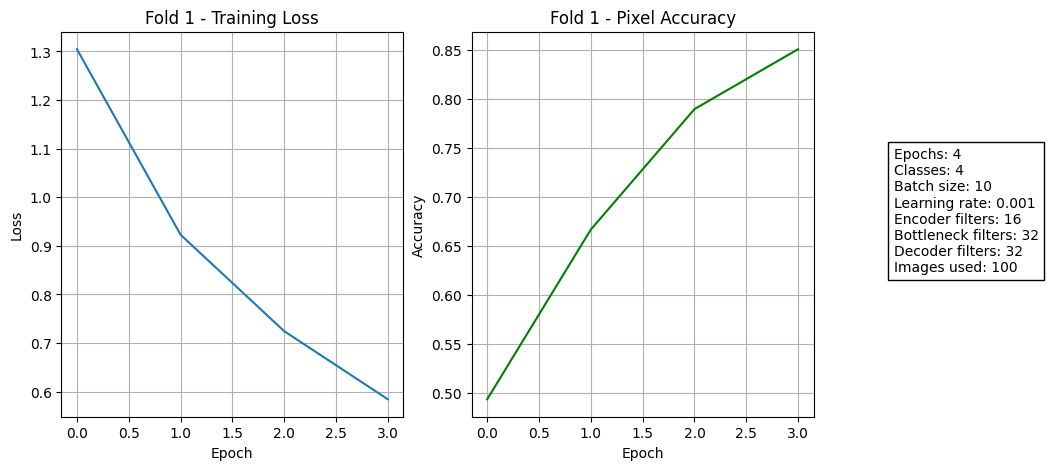

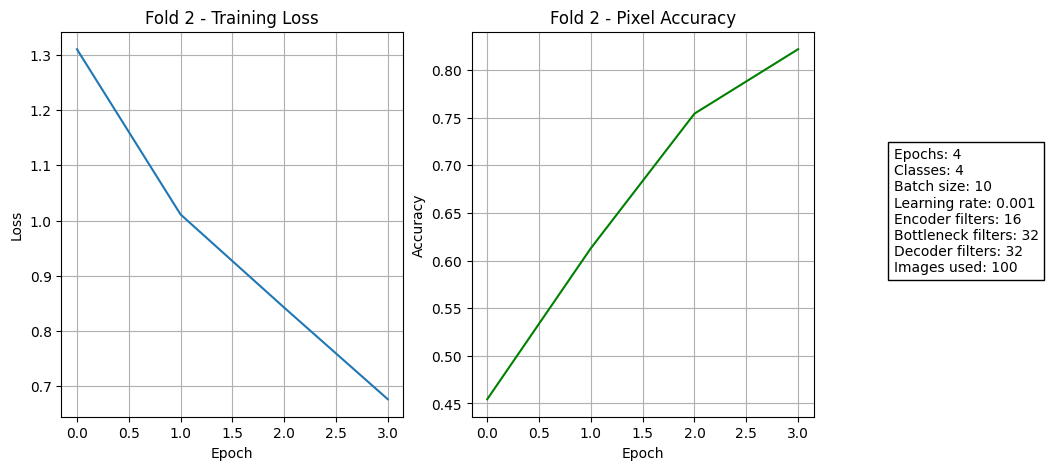

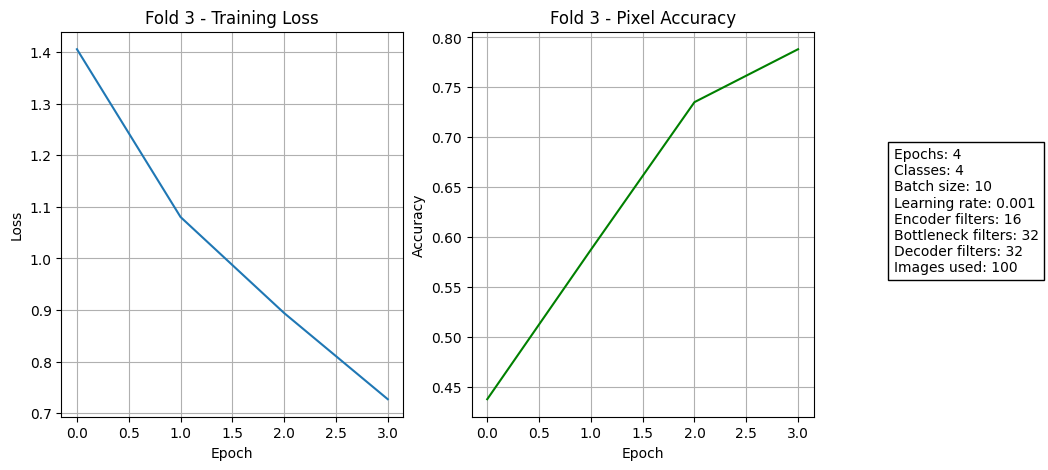

In [ ]:
# Visualizzazione curve

for fold in range(k):
  plt.figure(figsize=(15, 5))

  # Training Loss
  plt.subplot(1, 3, 1)
  plt.plot(all_train_losses[fold], label='Train Loss')
  plt.title(f'Fold {fold + 1} - Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid(True)

  # Pixel Accuracy
  plt.subplot(1, 3, 2)
  plt.plot(all_train_accuracies[fold], label='Pixel Accuracy', color='green')
  plt.title(f'Fold {fold + 1} - Pixel Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.grid(True)

  params_text = (
    f"Epochs: {num_epochs}\n"
    f"Classes: {n_classes}\n"
    f"Batch size: {batch_size}\n"
    f"Learning rate: {learning_rate}\n"
    f"Encoder filters: {n_filtri_enc}\n"
    f"Bottleneck filters: {n_filtri_bottleneck}\n"
    f"Decoder filters: {n_filtri_dec}\n"
    f"Images used: 100"
  )
  plt.gcf().text(0.68, 0.4, params_text, fontsize=10, bbox=dict(facecolor='white', edgecolor='black'))
  plt.show()

In [48]:
# Salvo i filtri di inizio dell'addestramento su drive (in modo da non
# doverli ri-calcolare ogni volta)

file_path = '/content/drive/MyDrive/Alzheimer-detection-project/filters.pkl'
if not os.path.exists(file_path):
  with open(file_path, 'wb') as f:
    pickle.dump(filters, f)
else:
  with open(file_path, 'rb') as f:
    filters = pickle.load(f)
  print("li carico dal drive")

li carico dal drive


# **TRAINING DEL MODELLO DI SEGMENTAZIONE**

In [49]:
# Salvo le immagini predette

def save_predictions(predictions, mask_paths, output_base_dir):
  for i, pred in enumerate(predictions):
    pred_label = np.argmax(pred, axis=-1).astype(np.uint8)
    pred_label = colorize_prediction(pred_label)
    rel_path = os.path.relpath(mask_paths[i], oasis1_path)
    rel_path = rel_path.replace(".npy", "_pred.png")
    save_path = os.path.join(oasis1_path, output_base_dir, rel_path)
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    pred_img = Image.fromarray(pred_label)
    pred_img.save(save_path)

In [50]:
def split_into_blocks(image_paths, mask_paths, num_blocks):
  total = len(image_paths)
  block_size = total // num_blocks
  blocks = []

  for i in range(num_blocks):
    start = i * block_size
    end = total if i == num_blocks - 1 else (i + 1) * block_size
    blocks.append((image_paths[start:end], mask_paths[start:end]))

  return blocks

In [51]:
def train_on_block(i,blocks,file_path,num_epochs,
                   batch_size, class_weights, learning_rate,n_classes,
                   global_best_val_loss, global_best_filters):
  print(f"\n Training block {i+1}/{len(blocks)}")
  image_block, mask_block = blocks[i]
  if i>0:
    file_path = f'/content/drive/MyDrive/Alzheimer-detection-project/checkpoint_{i}.pkl'
    with open(file_path, 'rb') as f:
      checkpoint = pickle.load(f)
    filters = checkpoint['filters']
    m = checkpoint['m']
    v = checkpoint['v']
    t = checkpoint['t']
    file_path = f'/content/drive/MyDrive/Alzheimer-detection-project/checkpoint_{i+1}.pkl'
  else:
    with open(file_path, 'rb') as f:
      filters = pickle.load(f)
    m, v, t = adam_init(filters)
    file_path = f'/content/drive/MyDrive/Alzheimer-detection-project/checkpoint_{i+1}.pkl'

  best_val_loss = float('inf')
  best_filters = None

  for epoch in range(num_epochs):
    epoch_losses = []
    gen = batch_generator(image_block, mask_block, batch_size)
    for X_batch, y_batch, batch_mask_paths in gen:
      loss, filters, predictions, gradients = train_step(
                X_batch, y_batch, filters, class_weights, learning_rate, n_classes)
      filters, m, v, t = adam_step(filters, gradients, m, v, t, learning_rate)
      epoch_losses.append(loss)
      print(f"Epoch {epoch + 1}, training Loss: {loss}")
      acc = pixel_accuracy(y_batch, predictions)
      print(f"Epoch {epoch +1}, Pixel Accuracy: {acc:.4f}")

    mean_loss = np.mean(epoch_losses)
    print(f"Block {i+1}, Epoch {epoch+1}, Training loss: {mean_loss:.4f}")

    val_gen = batch_generator(val_image_paths, val_mask_paths, batch_size)
    val_loss_total = 0
    for X_val, y_val, _ in val_gen:
      val_loss = validation_step(X_val, y_val, filters, class_weights, n_classes)
      val_loss_total += val_loss
    avg_val_loss = val_loss_total / (len(val_image_paths) // batch_size + 1)
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}")
    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      best_filters = {k: v.copy() for k, v in filters.items()}

  checkpoint = {
        'filters': best_filters,
        'm': m,
        'v': v,
        't': t
    }

  with open(file_path, 'wb') as f:
    pickle.dump(checkpoint, f)

  if best_val_loss < global_best_val_loss:
    global_best_val_loss = best_val_loss
    global_best_filters = {k: v.copy() for k, v in best_filters.items()}

  return global_best_val_loss, global_best_filters

In [52]:
n_blocks = 8
blocks_path = '/content/drive/MyDrive/Alzheimer-detection-project/blocks.pkl'
if not os.path.exists(blocks_path):
  blocks = split_into_blocks(image_paths_train, mask_paths_train, n_blocks)
  with open(blocks_path, 'wb') as f:
    pickle.dump(blocks, f)
else:
  with open(blocks_path, 'rb') as f:
    blocks = pickle.load(f)
  print("li carico da drive")

li carico da drive


In [ ]:
global_best_val_loss = float('inf')
global_best_filters = None

global_best_val_loss, global_best_filters = train_on_block(0, blocks,
    file_path, 3,10,class_weights,learning_rate, n_classes,
    global_best_val_loss, global_best_filters )

loss_path = '/content/drive/MyDrive/Alzheimer-detection-project/best_loss.pkl'
with open(loss_path, 'wb') as f:
  pickle.dump(global_best_val_loss, f)
bestfilters_path='/content/drive/MyDrive/Alzheimer-detection-project/best_filters.pkl'
with open(bestfilters_path, 'wb') as f:
  pickle.dump(global_best_filters, f)


 Training block 1/8
Epoch 1, training Loss: 0.5306630759934897
Epoch 1, Pixel Accuracy: 0.8650
Epoch 1, training Loss: 2.9728345776099063
Epoch 1, Pixel Accuracy: 0.4730
Epoch 1, training Loss: 0.6929664764734265
Epoch 1, Pixel Accuracy: 0.7536
Epoch 1, training Loss: 0.9044283669115184
Epoch 1, Pixel Accuracy: 0.7248
Epoch 1, training Loss: 1.1891729173033128
Epoch 1, Pixel Accuracy: 0.6421
Epoch 1, training Loss: 1.3989108313045475
Epoch 1, Pixel Accuracy: 0.6036
Epoch 1, training Loss: 1.3558021664274886
Epoch 1, Pixel Accuracy: 0.6091
Epoch 1, training Loss: 1.1673093472803309
Epoch 1, Pixel Accuracy: 0.6228
Epoch 1, training Loss: 1.0318850428645725
Epoch 1, Pixel Accuracy: 0.6517
Epoch 1, training Loss: 0.7728529448087764
Epoch 1, Pixel Accuracy: 0.7252
Epoch 1, training Loss: 0.6753246299973811
Epoch 1, Pixel Accuracy: 0.8039
Epoch 1, training Loss: 0.7613888253978478
Epoch 1, Pixel Accuracy: 0.6627
Epoch 1, training Loss: 0.8513917915418306
Epoch 1, Pixel Accuracy: 0.6129
Epoc

In [ ]:
loss_path = '/content/drive/MyDrive/Alzheimer-detection-project/best_loss.pkl'
bestfilters_path='/content/drive/MyDrive/Alzheimer-detection-project/best_filters.pkl'

with open(bestfilters_path, 'rb') as f:
  global_best_filters = pickle.load(f)
with open(loss_path, 'rb') as f:
  global_best_val_loss = pickle.load(f)

global_best_val_loss, global_best_filters = train_on_block(1, blocks,
    file_path, 3,10,class_weights,learning_rate, n_classes,
    global_best_val_loss, global_best_filters)

with open(bestfilters_path, 'wb') as f:
  pickle.dump(global_best_filters, f)
with open(loss_path, 'wb') as f:
  pickle.dump(global_best_val_loss, f)


 Training block 2/8
Epoch 1, training Loss: 0.3106520803405821
Epoch 1, Pixel Accuracy: 0.9317
Epoch 1, training Loss: 0.32218401832036514
Epoch 1, Pixel Accuracy: 0.9310
Epoch 1, training Loss: 0.35380123407983227
Epoch 1, Pixel Accuracy: 0.9124
Epoch 1, training Loss: 0.3394945974679539
Epoch 1, Pixel Accuracy: 0.9171
Epoch 1, training Loss: 0.3307566866592402
Epoch 1, Pixel Accuracy: 0.9243
Epoch 1, training Loss: 0.33784035670286355
Epoch 1, Pixel Accuracy: 0.9134
Epoch 1, training Loss: 0.33115842221711767
Epoch 1, Pixel Accuracy: 0.9265
Epoch 1, training Loss: 0.3299040888828948
Epoch 1, Pixel Accuracy: 0.9363
Epoch 1, training Loss: 0.33242524894052733
Epoch 1, Pixel Accuracy: 0.9219
Epoch 1, training Loss: 0.32128598307762346
Epoch 1, Pixel Accuracy: 0.9289
Epoch 1, training Loss: 0.3271676127831793
Epoch 1, Pixel Accuracy: 0.9273
Epoch 1, training Loss: 0.31973974727286447
Epoch 1, Pixel Accuracy: 0.9334
Epoch 1, training Loss: 0.33386130944954806
Epoch 1, Pixel Accuracy: 0.9

In [ ]:
loss_path = '/content/drive/MyDrive/Alzheimer-detection-project/best_loss.pkl'
bestfilters_path='/content/drive/MyDrive/Alzheimer-detection-project/best_filters.pkl'
with open(bestfilters_path, 'rb') as f:
  global_best_filters = pickle.load(f)
with open(loss_path, 'rb') as f:
  global_best_val_loss = pickle.load(f)

global_best_val_loss, global_best_filters = train_on_block(2, blocks,
    file_path, 3,10,class_weights,learning_rate, n_classes,
    global_best_val_loss, global_best_filters)

with open(bestfilters_path, 'wb') as f:
  pickle.dump(global_best_filters, f)
with open(loss_path, 'wb') as f:
  pickle.dump(global_best_val_loss, f)


 Training block 3/8
Epoch 1, training Loss: 0.30306825696301243
Epoch 1, Pixel Accuracy: 0.9344
Epoch 1, training Loss: 0.3323566728938551
Epoch 1, Pixel Accuracy: 0.9269
Epoch 1, training Loss: 0.30562109242162133
Epoch 1, Pixel Accuracy: 0.9375
Epoch 1, training Loss: 0.37404356988206394
Epoch 1, Pixel Accuracy: 0.9067
Epoch 1, training Loss: 0.28992947226421606
Epoch 1, Pixel Accuracy: 0.9380
Epoch 1, training Loss: 0.328642039302249
Epoch 1, Pixel Accuracy: 0.9232
Epoch 1, training Loss: 0.30483562670146674
Epoch 1, Pixel Accuracy: 0.9364
Epoch 1, training Loss: 0.3447891797978559
Epoch 1, Pixel Accuracy: 0.9220
Epoch 1, training Loss: 0.29395300642105116
Epoch 1, Pixel Accuracy: 0.9443
Epoch 1, training Loss: 0.3137262992784024
Epoch 1, Pixel Accuracy: 0.9348
Epoch 1, training Loss: 0.3209302292290884
Epoch 1, Pixel Accuracy: 0.9349
Epoch 1, training Loss: 0.3129527586971123
Epoch 1, Pixel Accuracy: 0.9369
Epoch 1, training Loss: 0.29560673913665636
Epoch 1, Pixel Accuracy: 0.942

In [ ]:
learning_rate= learning_rate*0.5

In [ ]:
loss_path = '/content/drive/MyDrive/Alzheimer-detection-project/best_loss.pkl'
bestfilters_path='/content/drive/MyDrive/Alzheimer-detection-project/best_filters.pkl'
with open(bestfilters_path, 'rb') as f:
  global_best_filters = pickle.load(f)
with open(loss_path, 'rb') as f:
  global_best_val_loss = pickle.load(f)

global_best_val_loss, global_best_filters = train_on_block(3, blocks,
    file_path, 3,10,class_weights,learning_rate, n_classes,
    global_best_val_loss, global_best_filters)

with open(bestfilters_path, 'wb') as f:
  pickle.dump(global_best_filters, f)
with open(loss_path, 'wb') as f:
  pickle.dump(global_best_val_loss, f)


 Training block 4/8
Epoch 1, training Loss: 0.30133487624607297
Epoch 1, Pixel Accuracy: 0.9363
Epoch 1, training Loss: 0.2869297265541804
Epoch 1, Pixel Accuracy: 0.9458
Epoch 1, training Loss: 0.2853863121182144
Epoch 1, Pixel Accuracy: 0.9370
Epoch 1, training Loss: 0.30798776644393183
Epoch 1, Pixel Accuracy: 0.9327
Epoch 1, training Loss: 0.2977501886547868
Epoch 1, Pixel Accuracy: 0.9395
Epoch 1, training Loss: 0.3185412737713853
Epoch 1, Pixel Accuracy: 0.9231
Epoch 1, training Loss: 0.3129272618657917
Epoch 1, Pixel Accuracy: 0.9324
Epoch 1, training Loss: 0.31612881549643396
Epoch 1, Pixel Accuracy: 0.9322
Epoch 1, training Loss: 0.3251064721680825
Epoch 1, Pixel Accuracy: 0.9300
Epoch 1, training Loss: 0.31493337713171526
Epoch 1, Pixel Accuracy: 0.9314
Epoch 1, training Loss: 0.28460201154806775
Epoch 1, Pixel Accuracy: 0.9438
Epoch 1, training Loss: 0.28751943652204576
Epoch 1, Pixel Accuracy: 0.9413
Epoch 1, training Loss: 0.31158894357704575
Epoch 1, Pixel Accuracy: 0.92

In [ ]:
loss_path = '/content/drive/MyDrive/Alzheimer-detection-project/best_loss.pkl'
bestfilters_path='/content/drive/MyDrive/Alzheimer-detection-project/best_filters.pkl'
with open(bestfilters_path, 'rb') as f:
  global_best_filters = pickle.load(f)
with open(loss_path, 'rb') as f:
  global_best_val_loss = pickle.load(f)

global_best_val_loss, global_best_filters = train_on_block(4, blocks,
    file_path, 3,10,class_weights,learning_rate, n_classes,
    global_best_val_loss, global_best_filters)

with open(bestfilters_path, 'wb') as f:
  pickle.dump(global_best_filters, f)
with open(loss_path, 'wb') as f:
  pickle.dump(global_best_val_loss, f)


 Training block 5/8
Epoch 1, training Loss: 0.2817378842051184
Epoch 1, Pixel Accuracy: 0.9428
Epoch 1, training Loss: 0.28100350642363153
Epoch 1, Pixel Accuracy: 0.9484
Epoch 1, training Loss: 0.32489478021837004
Epoch 1, Pixel Accuracy: 0.9331
Epoch 1, training Loss: 0.27222460839908275
Epoch 1, Pixel Accuracy: 0.9483
Epoch 1, training Loss: 0.2747515222578897
Epoch 1, Pixel Accuracy: 0.9375
Epoch 1, training Loss: 0.3038272618440753
Epoch 1, Pixel Accuracy: 0.9322
Epoch 1, training Loss: 0.29084951867736114
Epoch 1, Pixel Accuracy: 0.9328
Epoch 1, training Loss: 0.28518155080490326
Epoch 1, Pixel Accuracy: 0.9359
Epoch 1, training Loss: 0.2832842126005646
Epoch 1, Pixel Accuracy: 0.9386
Epoch 1, training Loss: 0.2919799378627104
Epoch 1, Pixel Accuracy: 0.9445
Epoch 1, training Loss: 0.2904935011784635
Epoch 1, Pixel Accuracy: 0.9332
Epoch 1, training Loss: 0.3102582292653223
Epoch 1, Pixel Accuracy: 0.9406
Epoch 1, training Loss: 0.2933954604856054
Epoch 1, Pixel Accuracy: 0.9441

In [ ]:
learning_rate=learning_rate*0.5

In [ ]:
loss_path = '/content/drive/MyDrive/Alzheimer-detection-project/best_loss.pkl'
bestfilters_path='/content/drive/MyDrive/Alzheimer-detection-project/best_filters.pkl'
with open(bestfilters_path, 'rb') as f:
  global_best_filters = pickle.load(f)
with open(loss_path, 'rb') as f:
  global_best_val_loss = pickle.load(f)

global_best_val_loss, global_best_filters = train_on_block(5, blocks,
    file_path, 3,10,class_weights,learning_rate, n_classes,
    global_best_val_loss, global_best_filters)

with open(bestfilters_path, 'wb') as f:
  pickle.dump(global_best_filters, f)
with open(loss_path, 'wb') as f:
  pickle.dump(global_best_val_loss, f)


 Training block 6/8
Epoch 1, training Loss: 0.2867706996855742
Epoch 1, Pixel Accuracy: 0.9402
Epoch 1, training Loss: 0.285191672708342
Epoch 1, Pixel Accuracy: 0.9379
Epoch 1, training Loss: 0.28524914148065006
Epoch 1, Pixel Accuracy: 0.9415
Epoch 1, training Loss: 0.29798638675715056
Epoch 1, Pixel Accuracy: 0.9413
Epoch 1, training Loss: 0.2761944194880302
Epoch 1, Pixel Accuracy: 0.9482
Epoch 1, training Loss: 0.27420896845539305
Epoch 1, Pixel Accuracy: 0.9413
Epoch 1, training Loss: 0.27874693235700704
Epoch 1, Pixel Accuracy: 0.9445
Epoch 1, training Loss: 0.28094611618137405
Epoch 1, Pixel Accuracy: 0.9455
Epoch 1, training Loss: 0.27885306254648645
Epoch 1, Pixel Accuracy: 0.9497
Epoch 1, training Loss: 0.26787973079960264
Epoch 1, Pixel Accuracy: 0.9500
Epoch 1, training Loss: 0.28664995975739505
Epoch 1, Pixel Accuracy: 0.9426
Epoch 1, training Loss: 0.2822635949125772
Epoch 1, Pixel Accuracy: 0.9468
Epoch 1, training Loss: 0.2967778575466239
Epoch 1, Pixel Accuracy: 0.93

In [ ]:
learning_rate=learning_rate*0.5

In [ ]:
loss_path = '/content/drive/MyDrive/Alzheimer-detection-project/best_loss.pkl'
bestfilters_path='/content/drive/MyDrive/Alzheimer-detection-project/best_filters.pkl'
with open(bestfilters_path, 'rb') as f:
  global_best_filters = pickle.load(f)
with open(loss_path, 'rb') as f:
  global_best_val_loss = pickle.load(f)

global_best_val_loss, global_best_filters = train_on_block(6, blocks,
    file_path, 3,10,class_weights,learning_rate, n_classes,
    global_best_val_loss, global_best_filters)

with open(bestfilters_path, 'wb') as f:
  pickle.dump(global_best_filters, f)
with open(loss_path, 'wb') as f:
  pickle.dump(global_best_val_loss, f)


 Training block 7/8
Epoch 1, training Loss: 0.28649425594128414
Epoch 1, Pixel Accuracy: 0.9405
Epoch 1, training Loss: 0.2839613231665418
Epoch 1, Pixel Accuracy: 0.9459
Epoch 1, training Loss: 0.285397639007737
Epoch 1, Pixel Accuracy: 0.9398
Epoch 1, training Loss: 0.28779269261683466
Epoch 1, Pixel Accuracy: 0.9352
Epoch 1, training Loss: 0.268736579146705
Epoch 1, Pixel Accuracy: 0.9542
Epoch 1, training Loss: 0.3007274035199019
Epoch 1, Pixel Accuracy: 0.9341
Epoch 1, training Loss: 0.28539366321377924
Epoch 1, Pixel Accuracy: 0.9345
Epoch 1, training Loss: 0.29062050686704727
Epoch 1, Pixel Accuracy: 0.9370
Epoch 1, training Loss: 0.27463012969864387
Epoch 1, Pixel Accuracy: 0.9392
Epoch 1, training Loss: 0.2796904623605077
Epoch 1, Pixel Accuracy: 0.9437
Epoch 1, training Loss: 0.2686817452901433
Epoch 1, Pixel Accuracy: 0.9469
Epoch 1, training Loss: 0.28507969850855996
Epoch 1, Pixel Accuracy: 0.9414
Epoch 1, training Loss: 0.29503210797228013
Epoch 1, Pixel Accuracy: 0.9355

In [ ]:
learning_rate=learning_rate*0.5

6.25e-05


In [ ]:
loss_path = '/content/drive/MyDrive/Alzheimer-detection-project/best_loss.pkl'
bestfilters_path='/content/drive/MyDrive/Alzheimer-detection-project/best_filters.pkl'
with open(bestfilters_path, 'rb') as f:
  global_best_filters = pickle.load(f)
with open(loss_path, 'rb') as f:
  global_best_val_loss = pickle.load(f)

global_best_val_loss, global_best_filters = train_on_block(7, blocks,
    file_path, 3,10,class_weights,learning_rate, n_classes,
    global_best_val_loss, global_best_filters)

with open(bestfilters_path, 'wb') as f:
  pickle.dump(global_best_filters, f)
with open(loss_path, 'wb') as f:
  pickle.dump(global_best_val_loss, f)


 Training block 8/8
Epoch 1, training Loss: 0.28392002772982533
Epoch 1, Pixel Accuracy: 0.9352
Epoch 1, training Loss: 0.2979478508715097
Epoch 1, Pixel Accuracy: 0.9436
Epoch 1, training Loss: 0.2817301661652627
Epoch 1, Pixel Accuracy: 0.9429
Epoch 1, training Loss: 0.287576725696273
Epoch 1, Pixel Accuracy: 0.9505
Epoch 1, training Loss: 0.27245081834390017
Epoch 1, Pixel Accuracy: 0.9461
Epoch 1, training Loss: 0.27229966958718216
Epoch 1, Pixel Accuracy: 0.9457
Epoch 1, training Loss: 0.29294052552497196
Epoch 1, Pixel Accuracy: 0.9454
Epoch 1, training Loss: 0.26738894674174585
Epoch 1, Pixel Accuracy: 0.9507
Epoch 1, training Loss: 0.2809654800780081
Epoch 1, Pixel Accuracy: 0.9494
Epoch 1, training Loss: 0.2803535054989739
Epoch 1, Pixel Accuracy: 0.9465
Epoch 1, training Loss: 0.27335841456159937
Epoch 1, Pixel Accuracy: 0.9443
Epoch 1, training Loss: 0.2784871465370511
Epoch 1, Pixel Accuracy: 0.9403
Epoch 1, training Loss: 0.28532128917727323
Epoch 1, Pixel Accuracy: 0.943

# **TESTING DEL MODELLO DI SEGMENTAZIONE**

In [53]:
# Predict step + valutazione del modello

def predict_evaluate_and_save(image_paths, mask_paths,class_weights, filters, n_classes, batch_size, output_dir):
  gen = batch_generator(image_paths, mask_paths, batch_size)
  dice_scores = []
  pixel_accs = []
  class_accs = []
  ious_list = []
  precisions_list = []
  recalls_list = []
  f1s_list = []

  for X_batch, y_batch, batch_mask_paths in gen:
    predictions = predict(X_batch, y_batch, filters,class_weights, n_classes)
    save_predictions(predictions, batch_mask_paths, output_dir)
    dice_mean, dice_per_class = dice_coefficient_from_softmax(y_batch, predictions)
    pixel_acc = pixel_accuracy(y_batch, predictions)
    class_acc = class_accuracy(y_batch, predictions)
    ious = iou_per_class(y_batch, predictions)
    precisions, recalls = precision_recall_per_class(y_batch, predictions)
    f1s = [2 * p * r / (p + r + 1e-7) for p, r in zip(precisions, recalls)]  # F1-score per classe

    dice_scores.append(dice_mean)
    pixel_accs.append(pixel_acc)
    class_accs.append(class_acc)
    ious_list.append(ious)
    precisions_list.append(precisions)
    recalls_list.append(recalls)
    f1s_list.append(f1s)

  return dice_scores, pixel_accs, class_accs, ious_list, precisions_list, recalls_list, f1s_list

In [54]:
# Predict step senza valutazione per salvare le maschere di train e validation

def predict_and_save(image_paths, mask_paths,class_weights, filters, n_classes, batch_size, output_dir):
  gen = batch_generator(image_paths, mask_paths, batch_size)
  for X_batch, y_batch, batch_mask_paths in gen:
    predictions = predict(X_batch, y_batch, filters,class_weights, n_classes)
    save_predictions(predictions, batch_mask_paths, output_dir)

In [56]:
# Salvataggio segmentazioni test set + valutazione modello
bestfilters_path='/content/drive/MyDrive/Alzheimer-detection-project/best_filters.pkl'
with open(bestfilters_path, 'rb') as f:
  filters = pickle.load(f)

print("\nsalvo segmentazioni del test set\n ")
ds, pa, ca, ious, pl, recalls, f1s=predict_evaluate_and_save(test_image_paths, test_mask_paths,class_weights, filters, n_classes, batch_size,
                 "/content/Alzheimer-detection-project/predizioni/test")



salvo segmentazioni del test set
 


In [59]:
# Salvataggio segmentazioni train set
print("\nsalvo segmentazioni del train set\n ")
predict_and_save(image_paths_train, mask_paths_train,class_weights, filters, n_classes, batch_size,
                 "/content/Alzheimer-detection-project/predizioni/train")


salvo segmentazioni del train set
 


KeyboardInterrupt: 

In [60]:
# Salvataggio segmentazioni validation set
print("\nsalvo segmentazioni del validation set\n ")
predict_and_save(val_image_paths, val_mask_paths,class_weights, filters, n_classes, batch_size,
                 "/content/Alzheimer-detection-project/predizioni/val")


salvo segmentazioni del validation set
 


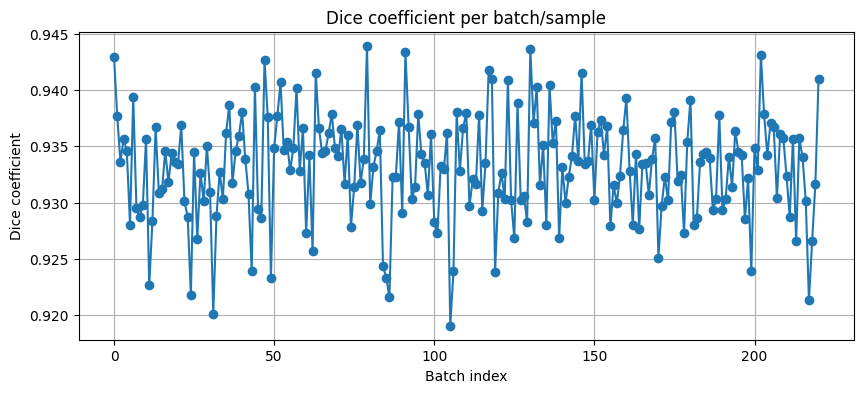

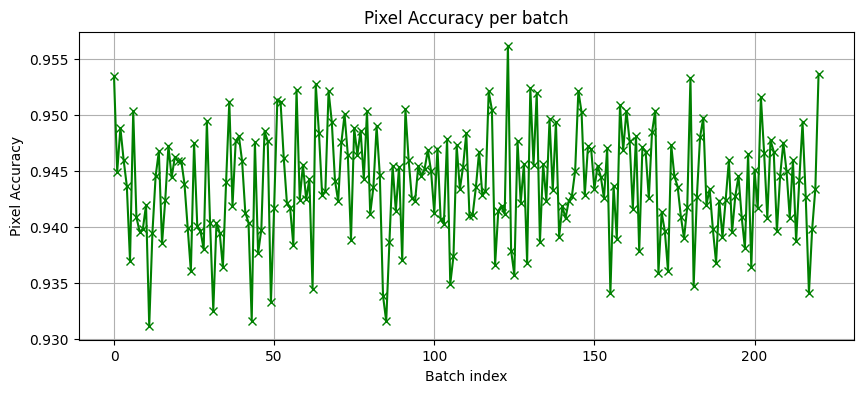

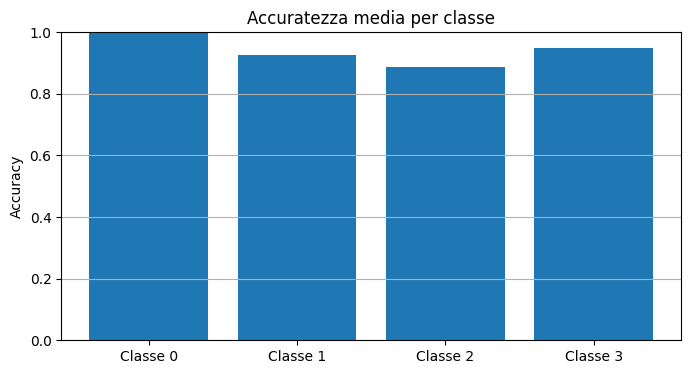

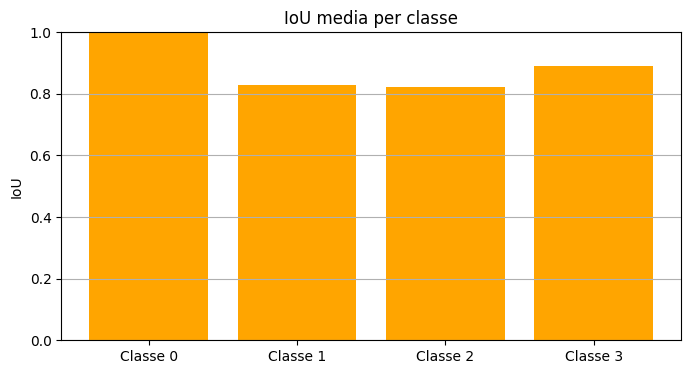

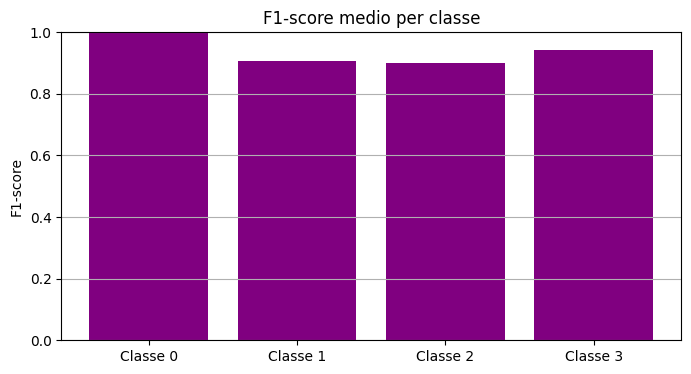

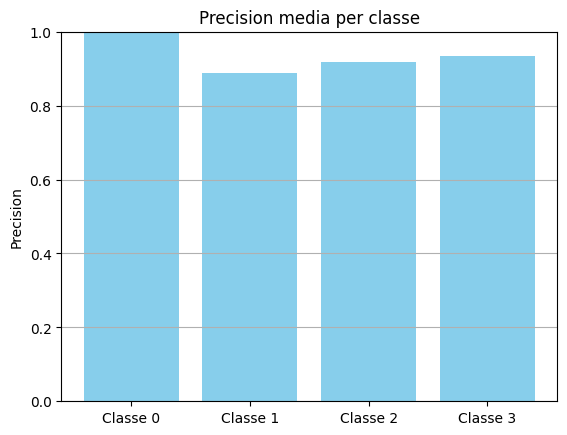

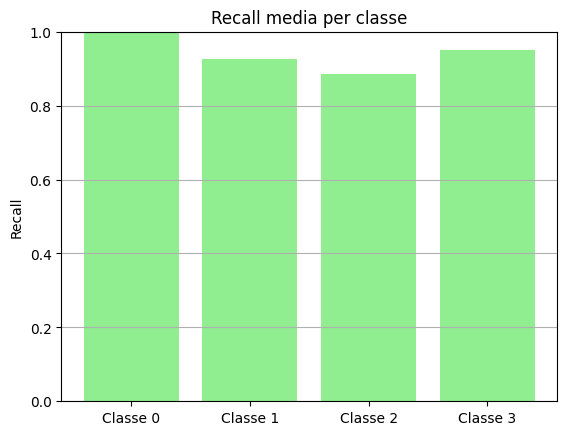

In [57]:
# VISUALIZZAZIONE DI GRAFICI

# Dice score medio per ogni batch
plt.figure(figsize=(10,4))
plt.plot(ds, marker='o')
plt.title("Dice coefficient per batch/sample")
plt.xlabel("Batch index")
plt.ylabel("Dice coefficient")
plt.grid(True)
plt.show()


# Accuratezza pixel-wise per ogni batch
plt.figure(figsize=(10,4))
plt.plot(pa, marker='x', color='green')
plt.title("Pixel Accuracy per batch")
plt.xlabel("Batch index")
plt.ylabel("Pixel Accuracy")
plt.grid(True)
plt.show()

# Media dell’accuratezza per ciascuna classe
ca = np.array(ca)
mean_ca_per_class = np.mean(ca, axis=0)
plt.figure(figsize=(8,4))
plt.bar(range(len(mean_ca_per_class)), mean_ca_per_class)
plt.xticks(range(len(mean_ca_per_class)), [f"Classe {i}" for i in range(len(mean_ca_per_class))])
plt.title("Accuratezza media per classe")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.grid(axis='y')
plt.show()


# Media dell'IoU per classe
iou_array = np.array(ious)
mean_iou_per_class = np.mean(iou_array, axis=0)
plt.figure(figsize=(8,4))
plt.bar(range(len(mean_iou_per_class)), mean_iou_per_class, color='orange')
plt.xticks(range(len(mean_iou_per_class)), [f"Classe {i}" for i in range(len(mean_iou_per_class))])
plt.title("IoU media per classe")
plt.ylabel("IoU")
plt.ylim(0,1)
plt.grid(axis='y')
plt.show()

#Media dell'F1 score per classe
f1_array = np.array(f1s)
mean_f1_per_class = np.mean(f1_array, axis=0)
plt.figure(figsize=(8,4))
plt.bar(range(len(mean_f1_per_class)), mean_f1_per_class, color='purple')
plt.xticks(range(len(mean_f1_per_class)), [f"Classe {i}" for i in range(len(mean_f1_per_class))])
plt.title("F1-score medio per classe")
plt.ylabel("F1-score")
plt.ylim(0,1)
plt.grid(axis='y')
plt.show()

# Media della Precision e Recall per classe
precision_array = np.array(pl)
recall_array = np.array(recalls)
mean_precision = precision_array.mean(axis=0)
mean_recall = recall_array.mean(axis=0)

classes = [f"Classe {i}" for i in range(mean_precision.shape[0])]

plt.bar(classes, mean_precision, color='skyblue')
plt.title("Precision media per classe")
plt.ylabel("Precision")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

plt.bar(classes, mean_recall, color='lightgreen')
plt.title("Recall media per classe")
plt.ylabel("Recall")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


In [61]:
# Codice per salvare le predizioni fatte su drive

src_folder = "/content/Alzheimer-detection-project/predizioni"
zip_path = "/content/drive/MyDrive/Alzheimer-detection-project/predictions.zip"

shutil.make_archive(base_name=zip_path.replace('.zip',''), format='zip', root_dir=src_folder)
print("Predizioni salvate in ZIP su Google Drive.")

Predizioni salvate in ZIP su Google Drive.


# **CONFRONTO CON ALTRI MODELLI**

# ***CLASSIFICAZIONE***

## OPERAZIONI PRELIMINARI

In [62]:
# estrazione della cartella predizioni da drive
import zipfile
zip_path = "/content/drive/MyDrive/Alzheimer-detection-project/predictions.zip"
extract_folder = "/content/Alzheimer-detection-project/predizioni"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_folder)
print("File estratti:", os.listdir(extract_folder))

File estratti: ['train', 'test', 'val']


In [64]:
# Creazione dataframe per classificazione

#MAPPA DA COLORI A CLASSI
color_to_class = {
    (0, 0, 255): "csf",
    (0, 255, 0): "gm",
    (255, 0, 0): "wm"
  }
path = "/content/drive/MyDrive/Alzheimer-detection-project/dataframe.pkl"
if not os.path.exists(path):
  my_data = []
  oasis1_path='/content/Alzheimer-detection-project/predizioni'
  div= [d for d in os.listdir(oasis1_path) if os.path.isdir(os.path.join(oasis1_path, d))]
  for division in div:
    division_path = os.path.join(oasis1_path, division)
    categories_folders = [d for d in os.listdir(division_path) if os.path.isdir(os.path.join(division_path, d))]
    for diagnosis in categories_folders:
      segmented_path = os.path.join(division_path, diagnosis, "mri segmented")
      patients = [p for p in os.listdir(segmented_path) if os.path.isdir(os.path.join(segmented_path, p))]

      for patient_id in patients:
        patient_folder = os.path.join(segmented_path, patient_id)
        volume_counts = {"wm": 0, "gm": 0, "csf": 0}

        for i in os.listdir(patient_folder):
          img_path = os.path.join(patient_folder, i)
          img = np.array(Image.open(img_path))
          for color, cls in color_to_class.items():
            mask = np.all(img == color, axis=-1)
            volume_counts[cls] += np.sum(mask)

        # volume cerebrale complessivo segmentato
        total_volume = volume_counts["wm"] + volume_counts["gm"] + volume_counts["csf"]
        # rapporti rispetto al volume cerebrale totale
        wm_ratio= volume_counts["wm"] / (total_volume + 1e-6)
        gm_ratio = volume_counts["gm"] / (total_volume + 1e-6)
        csf_ratio = volume_counts["csf"] / (total_volume + 1e-6)
        # rapporti tra parametri
        gm_to_csf_ratio = volume_counts["gm"] / (volume_counts["csf"] + 1e-6)
        wm_to_gm_ratio = volume_counts["wm"] / (volume_counts["gm"] + 1e-6)
        csf_to_wm_ratio = volume_counts["csf"] / (volume_counts["wm"] + 1e-6)
        csf_to_gm_ratio = volume_counts["csf"] / (volume_counts["gm"] + 1e-6)
        # logaritmi
        log_wm = np.log1p(volume_counts["wm"])
        log_gm = np.log1p(volume_counts["gm"])
        log_csf = np.log1p(volume_counts["csf"])


        my_data.append({
            "patient_id": patient_id,
            "diagnosis": diagnosis,
            "volume_wm": volume_counts["wm"],
            "volume_gm": volume_counts["gm"],
            "volume_csf": volume_counts["csf"],
            "volume_totale": total_volume,
            "wm_ratio": wm_ratio,
            "gm_ratio": gm_ratio,
            "csf_ratio": csf_ratio,
            "gm_to_csf_ratio": gm_to_csf_ratio,
            "wm_to_gm_ratio": wm_to_gm_ratio,
            "csf_to_wm_ratio": csf_to_wm_ratio,
            "csf_to_gm_ratio":csf_to_gm_ratio,
            "log_wm": log_wm,
            "log_gm":log_gm,
            "log_csf":log_csf
          })

  df = pd.DataFrame(my_data)
  df["patient_id"] = df["patient_id"].str.replace(" seg", "", regex=False)
else:
  print("lo scarico da drive")
  with open(path, "rb") as f:
    df = pickle.load(f)

In [66]:
# Preparazione dati
from sklearn.preprocessing import LabelEncoder

df_train = df[df["patient_id"].isin(train_ids)].reset_index(drop=True)
df_test = df[df["patient_id"].isin(test_ids + val_ids)].reset_index(drop=True)

features = [
    "volume_wm", "volume_gm", "volume_csf", "volume_totale",
    "wm_ratio", "gm_ratio", "csf_ratio",
    "gm_to_csf_ratio", "wm_to_gm_ratio", "csf_to_wm_ratio", "csf_to_gm_ratio",
    "log_wm", "log_gm", "log_csf"
]
features_train = df_train[features].values
features_test = df_test[features].values
mean = features_train.mean(axis=0)
std = features_train.std(axis=0)
X_train = (features_train - mean) / (std + 1e-6)
X_test = (features_test - mean) / (std + 1e-6)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train["diagnosis"]).astype(np.int64)
y_test = label_encoder.transform(df_test["diagnosis"]).astype(np.int64)
n_classes = len(label_encoder.classes_)

y_train_onehot = onehot_encoding(y_train, 3)
y_test_onehot = onehot_encoding(y_test, 3)

## METRICHE PER LA CLASSIFICAZIONE

In [67]:
# Metriche per la classificazione

def precision_per_class(y_pred, y_true_onehot, epsilon=1e-7):
  y_pred_labels = np.argmax(y_pred, axis=1)
  y_true_labels = np.argmax(y_true_onehot, axis=1)
  n_classes = y_true_onehot.shape[1]
  precisions = []

  for c in range(n_classes):
    tp = np.sum((y_pred_labels == c) & (y_true_labels == c))
    fp = np.sum((y_pred_labels == c) & (y_true_labels != c))
    precision = tp / (tp + fp + epsilon)
    precisions.append(precision)
  return precisions

def accuracy_classifier(y_pred, y_true_onehot):
  y_pred_labels = np.argmax(y_pred, axis=1)
  y_true_labels = np.argmax(y_true_onehot, axis=1)
  return np.mean(y_pred_labels == y_true_labels)

def recall_per_class(y_pred, y_true_onehot, epsilon=1e-7):
  y_pred_labels = np.argmax(y_pred, axis=1)
  y_true_labels = np.argmax(y_true_onehot, axis=1)
  n_classes = y_true_onehot.shape[1]
  recalls = []

  for c in range(n_classes):
    tp = np.sum((y_pred_labels == c) & (y_true_labels == c))
    fn = np.sum((y_pred_labels != c) & (y_true_labels == c))
    recall = tp / (tp + fn + epsilon)
    recalls.append(recall)
  return recalls

def f1_score_per_class(y_pred, y_true_onehot, epsilon=1e-7):
  precisions = precision_per_class(y_pred, y_true_onehot, epsilon)
  recalls = recall_per_class(y_pred, y_true_onehot, epsilon)
  f1s = []

  for p, r in zip(precisions, recalls):
    f1 = 2 * p * r / (p + r + epsilon)
    f1s.append(f1)
  return f1s

def confusion_matrix(y_pred, y_true_onehot):
  y_pred_labels = np.argmax(y_pred, axis=1)
  y_true_labels = np.argmax(y_true_onehot, axis=1)
  n_classes = y_true_onehot.shape[1]
  cm = np.zeros((n_classes, n_classes), dtype=int)
  for t, p in zip(y_true_labels, y_pred_labels):
    cm[t, p] += 1
  return cm

## CLASSIFICATORE LINEARE

In [68]:
def softmax_classifier(z):
  exp = np.exp(z - np.max(z, axis=1, keepdims=True))
  return exp / np.sum(exp, axis=1, keepdims=True)

def weighted_cross_entropy_loss_classifier(y_pred, y_true, weights):
  loss = - np.sum(weights * y_true * np.log(y_pred + 1e-12), axis=1)
  return np.mean(loss)

In [69]:
def train_classifier(X_train, y_train_onehot, W, b, n_epochs, lr, weights,
                          beta1=0.9, beta2=0.999):
  mW, vW = np.zeros_like(W), np.zeros_like(W)
  mb, vb = np.zeros_like(b), np.zeros_like(b)

  for epoch in range(1, n_epochs + 1):
    if epoch % 1000 == 0:
      lr *= 0.5
    z = np.dot(X_train, W) + b
    y_pred = softmax_classifier(z)
    loss = weighted_cross_entropy_loss_classifier(y_pred, y_train_onehot, weights)

    sample_weights = np.sum(weights * y_train_onehot, axis=1, keepdims=True)
    dz = (y_pred - y_train_onehot) * sample_weights / n_samples
    dW = np.dot(X_train.T, dz)
    db = np.sum(dz, axis=0, keepdims=True)

    mW = beta1 * mW + (1 - beta1) * dW
    vW = beta2 * vW + (1 - beta2) * (dW ** 2)
    mb = beta1 * mb + (1 - beta1) * db
    vb = beta2 * vb + (1 - beta2) * (db ** 2)
    mW_corr = mW / (1 - beta1 ** epoch)
    vW_corr = vW / (1 - beta2 ** epoch)
    mb_corr = mb / (1 - beta1 ** epoch)
    vb_corr = vb / (1 - beta2 ** epoch)
    W -= lr * mW_corr / (np.sqrt(vW_corr) + 1e-8)
    b -= lr * mb_corr / (np.sqrt(vb_corr) + 1e-8)

    if (epoch % 1000 == 0 or epoch == n_epochs or epoch==1):
      print(f"Epoch {epoch} | Loss: {loss:.4f} | LR: {lr:.6f}")

  return W, b

In [70]:
# Inizializzazione parametri
n_samples, n_features = X_train.shape
W = np.random.randn(n_features, 3) * 0.01
b = np.zeros((1, 3))
learning_rate = 0.001
n_epochs = 10000

# pesi dal numero di pazienti per classe
counts = np.array([30, 136, 70])
weights = 1.0 / counts

In [71]:
# Training del classificatore
W, b =  train_classifier(X_train, y_train_onehot, W, b,
                        n_epochs, learning_rate, weights)

# Test classificatore lineare
z_test = np.dot(X_test, W) + b
y_test_pred = softmax_classifier(z_test)

acc_test = accuracy_classifier(y_test_pred, y_test_onehot)
prec_test = precision_per_class(y_test_pred, y_test_onehot)
rec_test = recall_per_class(y_test_pred, y_test_onehot)
f1_test = f1_score_per_class(y_test_pred, y_test_onehot)
conf_matrix = confusion_matrix(y_test_pred, y_test_onehot)
class_names = label_encoder.classes_

print(f"\nTest Accuracy: {acc_test:.4f}")
for i, (prec, rec, f1) in enumerate(zip(prec_test, rec_test, f1_test)):
  print(f"Classe {i} ({class_names[i]}):")
  print(f"  Precision: {prec:.4f}")
  print(f"  Recall:    {rec:.4f}")
  print(f"  F1-score:  {f1:.4f}\n")

table = conf_matrix.tolist() if hasattr(conf_matrix, 'tolist') else list(conf_matrix)
class_names = list(class_names)
print(tabulate(table, headers=class_names, showindex=class_names, tablefmt='fancy_grid'))

Epoch 1 | Loss: 0.0137 | LR: 0.001000
Epoch 1000 | Loss: 0.0086 | LR: 0.000500
Epoch 2000 | Loss: 0.0085 | LR: 0.000250
Epoch 3000 | Loss: 0.0085 | LR: 0.000125
Epoch 4000 | Loss: 0.0085 | LR: 0.000063
Epoch 5000 | Loss: 0.0085 | LR: 0.000031
Epoch 6000 | Loss: 0.0085 | LR: 0.000016
Epoch 7000 | Loss: 0.0085 | LR: 0.000008
Epoch 8000 | Loss: 0.0085 | LR: 0.000004
Epoch 9000 | Loss: 0.0085 | LR: 0.000002
Epoch 10000 | Loss: 0.0085 | LR: 0.000001

Test Accuracy: 0.6744
Classe 0 (Mild to Moderate Dementia):
  Precision: 0.2500
  Recall:    0.1818
  F1-score:  0.2105

Classe 1 (Non Demented):
  Precision: 0.9500
  Recall:    0.7600
  F1-score:  0.8444

Classe 2 (Very Mild Dementia):
  Precision: 0.4737
  Recall:    0.7200
  F1-score:  0.5714

╒═══════════════════════════╤═════════════════════════════╤════════════════╤══════════════════════╕
│                           │   Mild to Moderate Dementia │   Non Demented │   Very Mild Dementia │
╞═══════════════════════════╪══════════════════════

## KNN

In [72]:
# Funzioni per classificazione KNNN

def knn_predict(X_train, y_train, x_test, k, class_weights):
  dist = np.linalg.norm(X_train - x_test, axis=1)
  idxs = np.argsort(dist)[:k]
  nearest_labels = y_train[idxs]
  nearest_dists = dist[idxs]

  weights = 1 / (nearest_dists + 1e-5)
  class_votes = {}
  for label, w in zip(nearest_labels, weights):
    class_votes[label] = class_votes.get(label, 0) + w * class_weights[label]

  return max(class_votes, key=class_votes.get)

def knn_predict_all(X_train, y_train, X_test, k, class_weights):
  return np.array([knn_predict(X_train, y_train, x_test, k,class_weights) for x_test in X_test])

In [73]:
# Test classificazione con KNN
k = 3
y_pred = knn_predict_all(X_train, y_train, X_test, k,weights)
y_pred_onehot = onehot_encoding(y_pred, 3)

acc = accuracy_classifier(y_pred_onehot, y_test_onehot)
prec = precision_per_class(y_pred_onehot, y_test_onehot)
rec = recall_per_class(y_pred_onehot, y_test_onehot)
f1 = f1_score_per_class(y_pred_onehot, y_test_onehot)
cm = confusion_matrix(y_pred_onehot, y_test_onehot)

print(f"\nTest Accuracy: {acc:.4f}")
for i, (p, r, f) in enumerate(zip(prec, rec, f1)):
    print(f"Classe {i} ({class_names[i]}):")
    print(f"  Precision: {p:.4f}")
    print(f"  Recall:    {r:.4f}")
    print(f"  F1-score:  {f:.4f}\n")

table = cm.tolist() if hasattr(cm, 'tolist') else list(cm)
print(tabulate(table, headers=class_names, showindex=class_names, tablefmt='fancy_grid'))


Test Accuracy: 0.7093
Classe 0 (Mild to Moderate Dementia):
  Precision: 0.3571
  Recall:    0.4545
  F1-score:  0.4000

Classe 1 (Non Demented):
  Precision: 0.9524
  Recall:    0.8000
  F1-score:  0.8696

Classe 2 (Very Mild Dementia):
  Precision: 0.5333
  Recall:    0.6400
  F1-score:  0.5818

╒═══════════════════════════╤═════════════════════════════╤════════════════╤══════════════════════╕
│                           │   Mild to Moderate Dementia │   Non Demented │   Very Mild Dementia │
╞═══════════════════════════╪═════════════════════════════╪════════════════╪══════════════════════╡
│ Mild to Moderate Dementia │                           5 │              0 │                    6 │
├───────────────────────────┼─────────────────────────────┼────────────────┼──────────────────────┤
│ Non Demented              │                           2 │             40 │                    8 │
├───────────────────────────┼─────────────────────────────┼────────────────┼──────────────────────┤


## AUTO ENCODER PER ANOMALY DETECTION

### *Funzioni per il forward pass*

In [ ]:
# decoder per AE
def decoder_autoencoder(imgs, filters):
  saved = {}
  saved["input_upsample1"] = imgs
  c = upsample(imgs)
  saved["upsampled1"] = c
  saved["input_conv1"] = c
  c = convolve(c, filters["decoder1"])
  saved["input_relu1"] = c
  c = ReLU(c)
  saved["input_upsample2"] = c
  c = upsample(c)
  saved["upsampled2"] = c
  saved["input_conv2"] = c
  c = convolve(c, filters["decoder2"])
  saved["input_relu2"] = c
  c = ReLU(c)

  return c, saved

In [ ]:
# Funzione di loss
def mse_loss(x, x_reconstructed):

  diff = x - x_reconstructed
  loss = np.mean(diff ** 2)
  return loss

### *Funzioni per il backward pass*

In [ ]:
# Backward del decoder per AE

def decoder_backward_autoencoder(dout, saved, filters):
  grads = [None, None]
  drelu2 = ReLU_backward(dout, saved["input_relu2"])
  dconv2, grads[1] = convolve_backward(drelu2, saved["input_conv2"], filters["decoder2"])
  drelu1 = ReLU_backward(dconv2, saved["input_relu1"])
  dconv1, grads[0] = convolve_backward(drelu1, saved["input_conv1"], filters["decoder1"])
  dinput = upsample_backward(dconv1, saved["input_upsample"])

  return dinput, grads

In [ ]:
# Backward per la funzione di loss

def mse_loss_backward(x, x_reconstructed):
  N = np.prod(x.shape)  # numero totale elementi
  grad = 2 * (x_reconstructed - x) / N
  return grad

### *FUNZIONI DI TRAINING*

In [ ]:
# Funzione di forward per AE

def forward_pass_autoencoder(input_img, filters):
  saved_fwd = {}

  encoded_img, skip_connections, saved_encoder = encoder(input_img, filters)
  saved_fwd["saved_encoder"] = saved_encoder

  bottleneck_img, saved_bot = bottleneck(encoded_img, filters)
  saved_fwd["saved_bot"] = saved_bot

  decoded_img, saved_decoder = decoder(bottleneck_img, skip_connections, filters)
  saved_fwd["saved_decoder"] = saved_decoder

  output_img = decoded_img
  loss = np.mean((input_img - output_img) ** 2)
  return output_img, loss, saved_fwd, skip_connections

In [ ]:
# funzione di backward per AE

def backward_pass_autoencoder(input_img, output_img, saved_fwd, filters, skip_connections):
  dout = mse_loss_backward(input_img, output_img)
  d_decoder, decoder_grads = decoder_backward(dout, saved_fwd["saved_decoder"], filters)
  d_bottleneck, bottleneck_grads = bottleneck_backward(d_decoder, saved_fwd["saved_bot"], filters)
  d_encoder, encoder_grads = encoder_backward(d_bottleneck, skip_connections, filters, saved_fwd["saved_encoder"])

  grads = {
        "encoder": encoder_grads,
        "bottleneck": bottleneck_grads,
        "decoder": decoder_grads
    }

  return d_encoder, grads

In [ ]:
# Funzione per il training dell'AE

def train_step_autoencoder(imgs, filters):
  output, loss, saved_fwd = forward_pass_autoencoder(imgs, filters)
  grads = backward_pass_autoencoder(imgs, output, saved_fwd, filters)

  return loss, grads, output

In [ ]:
# Funzione per il validation dell'AE

def validation_step_autoencoder(X_batch, filters):
  reconstructed, loss, _ = forward_pass_autoencoder(X_batch, filters)
  return loss

## **TRAINING DEL MODELLO**

In [ ]:
def train_autoencoder_block(i, blocks, file_path, num_epochs,
                            batch_size, learning_rate,
                            global_best_val_loss, global_best_filters):
  print(f"\nTraining autoencoder block {i + 1}/{len(blocks)}")
  image_block, _ = blocks[i]  # L'autoencoder ricostruisce le immagini stesse

  if i > 0:
    file_path = f'/content/drive/MyDrive/Alzheimer-detection-project/autoencoder_checkpoint_{i}.pkl'
    with open(file_path, 'rb') as f:
      checkpoint = pickle.load(f)
    filters = checkpoint['filters']
    m = checkpoint['m']
    v = checkpoint['v']
    t = checkpoint['t']
    file_path = f'/content/drive/MyDrive/Alzheimer-detection-project/autoencoder_checkpoint_{i+1}.pkl'
  else:
    with open(file_path, 'rb') as f:
      filters = pickle.load(f)
    m, v, t = adam_init(filters)
    file_path = f'/content/drive/MyDrive/Alzheimer-detection-project/autoencoder_checkpoint_{i+1}.pkl'

  best_val_loss = float('inf')
  best_filters = None

  for epoch in range(num_epochs):
    epoch_losses = []
    gen = batch_generator(image_block, image_block, batch_size)  # X == y per autoencoder
    for X_batch, _, _ in gen:
      loss, filters, predictions, gradients = train_step_autoencoder(X_batch, filters, learning_rate)
      filters, m, v, t = adam_step(filters, gradients, m, v, t, learning_rate)
      epoch_losses.append(loss)
      print(f"Epoch {epoch + 1}, Training Loss: {loss:.4f}")

    mean_loss = np.mean(epoch_losses)
    print(f"Block {i + 1}, Epoch {epoch + 1}, Training Loss: {mean_loss:.4f}")

    val_gen = batch_generator(val_image_paths, val_image_paths, batch_size)
    val_loss_total = 0
    for X_val, _, _ in val_gen:
      val_loss = validation_step_autoencoder(X_val, filters)
      val_loss_total += val_loss
    avg_val_loss = val_loss_total / (len(val_image_paths) // batch_size + 1)
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_filters = {k: v.copy() for k, v in filters.items()}

  checkpoint = {
        'filters': best_filters,
        'm': m,
        'v': v,
        't': t
    }

  with open(file_path, 'wb') as f:
    pickle.dump(checkpoint, f)

  if best_val_loss < global_best_val_loss:
    global_best_val_loss = best_val_loss
    global_best_filters = {k: v.copy() for k, v in best_filters.items()}

  return global_best_val_loss, global_best_filters

In [ ]:
# Parametri
n_filtri_enc = 16
n_filtri_bottleneck = 32
n_filtri_dec = 16  # match con encoder
input_channels = 1
output_channels = 1  # grayscale
latent_dim = n_filtri_bottleneck  # opzionale

# Inizializzazione filtri
filters = {
    # Encoder
    "encoder1": he_init((n_filtri_enc, 3, 3, input_channels)),
    "encoder2": he_init((n_filtri_enc, 3, 3, n_filtri_enc)),

    # Bottleneck
    "bottleneck1": he_init((n_filtri_bottleneck, 3, 3, n_filtri_enc)),
    "bottleneck2": he_init((n_filtri_bottleneck, 3, 3, n_filtri_bottleneck)),

    # Decoder
    "decoder1": he_init((n_filtri_dec, 3, 3, n_filtri_bottleneck)),
    "decoder2": he_init((n_filtri_dec, 3, 3, n_filtri_dec)),

    # Output layer: ricostruisce immagine (1 canale)
    "final": np.random.randn(1, 1, n_filtri_dec, output_channels) * np.sqrt(2. / n_filtri_dec)
}
